# Import Libraries

In [1]:
!pip install numpy pandas matplotlib seaborn statsmodels --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import convolve, butter, sosfiltfilt

# About Weather Derivatives

Weather derivatives are financial instruments used to hedge or speculate on weather-related risks, primarily temperature, precipitation, snowfall, or wind. 

These derivatives typically have a basis to an index that measures a particular aspect of weather. For example, an index might be the total rainfall over a specified period in a specific place. Another can be for the number of times the temperature falls below freezing. 

The derivatives are different from insurance. Insurance covers low-probability, catastrophic weather events such as hurricanes, earthquakes, and tornadoes. In contrast, derivatives cover higher-probability events such as a dryer-than-expected summer.

Source: https://www.investopedia.com/terms/w/weatherderivative.asp

# Terminology of Degree Days

A **degree day** compares the mean outdoor temperatures recorded for a location to a standard temperature, usually 65° Fahrenheit (F) in the United States.

$$
\text{Average Temperature}: T_n = \frac{T^{max} + T^{min}}2
$$

**Heating Degree Days (HDD)** are a measure of how cold the temperature was on a given day or during a period of days. For example, a day with a mean temperature of 40°F has 25 HDDs.
**Cooling Degree Days (CDD)** are a measure of how hot the temperature was on a given day or during a period of days. A day with a mean temperature of 80°F has 15 CDDs.
$$
HDD_n = (65 - T_n)^+ \\
CDD_n = (T_n - 65)^+
$$

Meanwhile, when calculating the payoff function it tends to use **Cumulative Degree Days (DD)**, which is calculated as such:
$$
\text{Heating Degree Season}: DD = H_n = \sum^N_n{HDD_n} \\
\text{Cooling Degree Season}: DD = C_n = \sum^N_n{CDD_n}
$$
where n $\in$ N

Based on the price of the contract unit (u) and the strike level (K), the payoff formula is:
$$
Payoff = (DD-K)^+
$$

Meanwhile, a popular OTC product called **Call with Cap** has the following payoff formula:
$$
f(DD) = MIN[\alpha(DD-K)^+, C]
$$
where C is the Cap

Source: https://www.eia.gov/energyexplained/units-and-calculators/degree-days.php

# Statistical Analysis of Temperature Data
## Data Cleaning

We will use the minimum and maximum temperature data from the Australian Government Bureau of Meteorology (BOM): http://www.bom.gov.au/climate/data/stations/

The following images show the filter used:

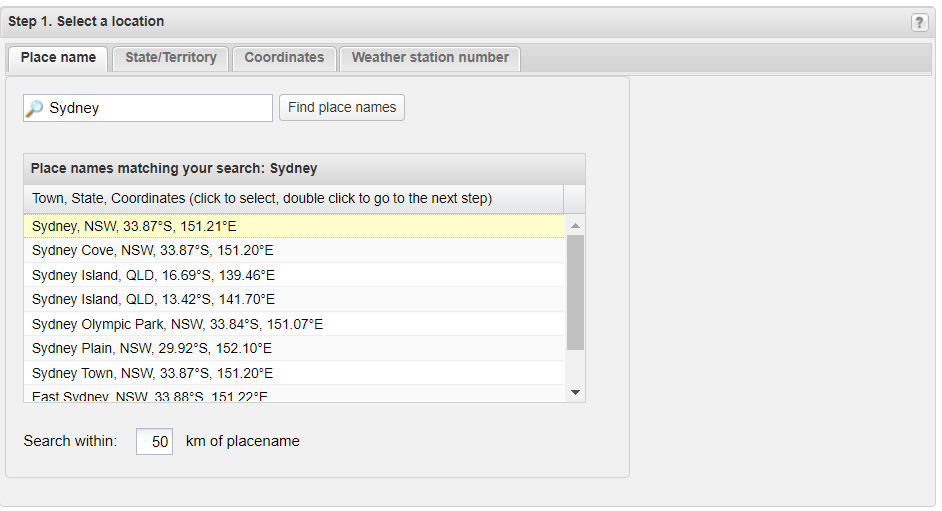

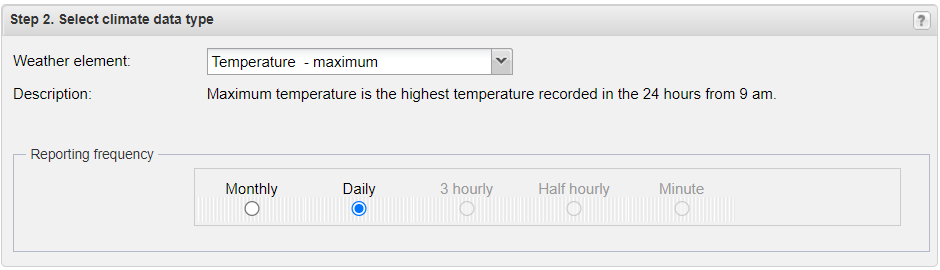

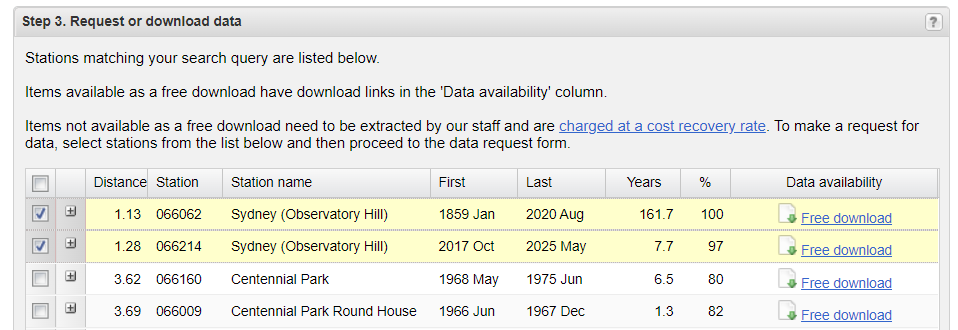

In [3]:
#Set current working directory to dataset folder
dir_path = os.path.dirname(os.path.realpath('__file__'))
data_folder = os.path.join(dir_path, 'dataset')
os.chdir(data_folder)

### Remove Latest Date due to Missing Maximum Temperature
Based on the analysis below, we can see that there will always be a missing data pont for maximum temperature as compared to the minimum temperature.

According to the BOM, for daily observations:
- Maximum temperature, highest value recorded against the previous day.
- Minimum temperature, lowest value recorded against the day of observation.

Therefore, we should drop the extra minimum temperature data as there is no way to get the actual maximum temperature.

Source: http://www.bom.gov.au/climate/data/stations/about-weather-station-data.shtml

In [4]:
max_temp_1859 = pd.read_csv('sydney_max_temp_1859_2020.csv')
min_temp_1859 = pd.read_csv('sydney_min_temp_1859_2020.csv')
print(f"Max Temp Shape: {max_temp_1859.shape}\nMin Temp Shape: {min_temp_1859.shape}")
max_temp_1859.head(5)

Max Temp Shape: (59047, 8)
Min Temp Shape: (59048, 8)


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y


In [5]:
#31 Aug 2020 is missing from Max Temp
check_1859 = max_temp_1859.loc[:, ['Year', 'Month', 'Day']]
check_1859 = pd.concat([check_1859, min_temp_1859.loc[:, ['Year', 'Month', 'Day']]], axis=0)
check_1859.loc[~check_1859.duplicated(keep=False)]

,Year,Month,Day
59047,2020,8,31


In [6]:
max_temp_2017 = pd.read_csv('sydney_max_temp_2017_2025.csv')
min_temp_2017 = pd.read_csv('sydney_min_temp_2017_2025.csv')
print(f"Max Temp Shape: {max_temp_2017.shape}\nMin Temp Shape: {min_temp_2017.shape}")
max_temp_2017.head(5)

Max Temp Shape: (3044, 8)
Min Temp Shape: (3045, 8)


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66214,2017,1,1,NaN,NaN,NaN
1,IDCJAC0010,66214,2017,1,2,NaN,NaN,NaN
2,IDCJAC0010,66214,2017,1,3,NaN,NaN,NaN
3,IDCJAC0010,66214,2017,1,4,NaN,NaN,NaN
4,IDCJAC0010,66214,2017,1,5,NaN,NaN,NaN


In [7]:
#3 May 2025 is missing from Max Temp
check_2017 = max_temp_2017.loc[:, ['Year', 'Month', 'Day']]
check_2017 = pd.concat([check_2017, min_temp_2017.loc[:, ['Year', 'Month', 'Day']]], axis=0)
check_2017.loc[~check_2017.duplicated(keep=False)]

,Year,Month,Day
3044,2025,5,3


In [8]:
#Remove latest date
min_temp_2017 = min_temp_2017.iloc[:-1]
min_temp_1859 = min_temp_1859.iloc[:-1]

### Abnormal Days of Accumulation for 1859~2020 Data
Each table has only one Product Code and Station Number. However for the 1859~2020 data, we see two different values for Days of Accumulation.

Given that the dataset spans over a long period and it is only one instance, we can ignore it as it would not significantly alter the result.

In [9]:
max_temp_2017.nunique(), min_temp_2017.nunique()

(Product code                                     1
 Bureau of Meteorology station number             1
 Year                                             9
 Month                                           12
 Day                                             31
 Maximum temperature (Degree C)                 240
 Days of accumulation of maximum temperature      1
 Quality                                          2
 dtype: int64,
 Product code                                     1
 Bureau of Meteorology station number             1
 Year                                             9
 Month                                           12
 Day                                             31
 Minimum temperature (Degree C)                 193
 Days of accumulation of minimum temperature      1
 Quality                                          2
 dtype: int64)

In [10]:
min_temp_1859.nunique(), max_temp_1859.nunique()

(Product code                                     1
 Bureau of Meteorology station number             1
 Year                                           162
 Month                                           12
 Day                                             31
 Minimum temperature (Degree C)                 241
 Days of accumulation of minimum temperature      2
 Quality                                          1
 dtype: int64,
 Product code                                     1
 Bureau of Meteorology station number             1
 Year                                           162
 Month                                           12
 Day                                             31
 Maximum temperature (Degree C)                 334
 Days of accumulation of maximum temperature      2
 Quality                                          1
 dtype: int64)

In [11]:
min_temp_1859['Days of accumulation of minimum temperature'].value_counts(), max_temp_1859['Days of accumulation of maximum temperature'].value_counts()

(Days of accumulation of minimum temperature
 1.0    58762
 2.0        1
 Name: count, dtype: int64,
 Days of accumulation of maximum temperature
 1.0    58761
 2.0        1
 Name: count, dtype: int64)

### Create New Features and Impute Missing Data

In [12]:
#Create Date
def datetime(row:pd.Series) -> dt.datetime:
    """
    Input: row must contain the Year, Month, Day columns.
    Output: a datetime value in the YYYY-MM-DD format
    """
    return dt.datetime(row.Year, row.Month, row.Day)

min_temp_2017['Date'] = min_temp_2017.apply(datetime, axis=1)
max_temp_2017['Date'] = max_temp_2017.apply(datetime, axis=1)
min_temp_1859['Date'] = min_temp_1859.apply(datetime, axis=1)
max_temp_1859['Date'] = max_temp_1859.apply(datetime, axis=1)

min_temp_2017.head(5)

,Product code,Bureau of Meteorology station number,Year,Month,Day,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality,Date
0,IDCJAC0011,66214,2017,1,1,NaN,NaN,NaN,2017-01-01
1,IDCJAC0011,66214,2017,1,2,NaN,NaN,NaN,2017-01-02
2,IDCJAC0011,66214,2017,1,3,NaN,NaN,NaN,2017-01-03
3,IDCJAC0011,66214,2017,1,4,NaN,NaN,NaN,2017-01-04
4,IDCJAC0011,66214,2017,1,5,NaN,NaN,NaN,2017-01-05


BoM has two station numbers for the same location (Observatory Hill).

Since we only care about the temperature of the area, either one works. Hence, we can merge the two together.

In [13]:
min_temp_1859.loc[min_temp_1859['Year'] == 2017].head(5)

,Product code,Bureau of Meteorology station number,Year,Month,Day,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality,Date
57709,IDCJAC0011,66062,2017,1,1,22.7,1.0,Y,2017-01-01
57710,IDCJAC0011,66062,2017,1,2,21.2,1.0,Y,2017-01-02
57711,IDCJAC0011,66062,2017,1,3,18.5,1.0,Y,2017-01-03
57712,IDCJAC0011,66062,2017,1,4,20.1,1.0,Y,2017-01-04
57713,IDCJAC0011,66062,2017,1,5,19.6,1.0,Y,2017-01-05


In [14]:
#Select only necessary data
filter_min_temp_1859 = min_temp_1859.loc[:, ['Date', 'Minimum temperature (Degree C)']]
filter_min_temp_1859 = filter_min_temp_1859.set_index('Date')
filter_min_temp_2017 = min_temp_2017.loc[:, ['Date', 'Minimum temperature (Degree C)']]
filter_min_temp_2017 = filter_min_temp_2017.set_index('Date')

#Fill NaN values in one df from another df and clean up
min_temp = filter_min_temp_1859.combine_first(filter_min_temp_2017)
min_temp = min_temp.rename(columns={'Minimum temperature (Degree C)': 'T_MIN'})

In [15]:
#Select only necessary data
filter_max_temp_1859 = max_temp_1859.loc[:, ['Date', 'Maximum temperature (Degree C)']]
filter_max_temp_1859 = filter_max_temp_1859.set_index('Date')
filter_max_temp_2017 = max_temp_2017.loc[:, ['Date', 'Maximum temperature (Degree C)']]
filter_max_temp_2017 = filter_max_temp_2017.set_index('Date')

#Fill NaN values in one df from another df and clean up
max_temp = filter_max_temp_1859.combine_first(filter_max_temp_2017)
max_temp = max_temp.rename(columns={'Maximum temperature (Degree C)': 'T_MAX'})

print(f'Is the date range the same: {np.array_equal(min_temp.index, max_temp.index)}')

Is the date range the same: True


In [16]:
#Merge data
df = pd.merge(min_temp, max_temp, how='inner', on='Date')
df.isnull().sum()

T_MIN    155
T_MAX    158
dtype: int64

In order to calculate $T_n$, we need both the minimum and maximum temperature. Since there is missing values, we need to either remove or impute the rows.

In the tutorial, these rows were removed. However, my intuition is that the best prediction of today's temperature will likely be close to yesterday's.

Moreover, since we have the benefit of hindsight, we can improve our estimate using the average of the temperature the previous and the next day.

In [17]:
null_values = min_temp.loc[min_temp.isnull().values].index
min_temp.loc[min_temp.isnull().values].head(5)

,T_MIN
Date,
1860-12-21,NaN
1864-03-20,NaN
1865-06-25,NaN
1868-02-13,NaN
1869-04-06,NaN


In [18]:
def impute_missing_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Impute missing values using one of the following: the average of the previous and next values, previous value, or next value.
    
    Input:
    df: temperature data sorted in chronological order.
    
    Return:
    result_df: temperature data with missing values imputed.
    """
    #Ensure that the first and last index has a value
    try:
        first_idx = df.iloc[0].values
        last_idx = df.iloc[-1].values
    except AttributeError:
        first_idx = df.iloc[0]
        last_idx = df.iloc[-1]
    if np.isnan(first_idx) or np.isnan(last_idx):
        print("Please ensure that the first and last values are not empty.")
        return

    #Calculate Averages    
    prev_rows = df.shift(periods=1)
    next_rows = df.shift(periods=-1)
    avg = (prev_rows+next_rows)/2

    #Impute the value using whichever is not empty
    result_df = df.combine_first(avg).combine_first(prev_rows).combine_first(next_rows)
    return result_df

min_temp = impute_missing_values(min_temp)
max_temp = impute_missing_values(max_temp)

min_temp.loc[null_values].head(5)

,T_MIN
Date,
1860-12-21,13.45
1864-03-20,15.90
1865-06-25,8.50
1868-02-13,18.80
1869-04-06,17.20


After imputing the missing values, we still have two missing values for T_MAX. If we look further back and forward, we see that the temperature is 18.6 and 18.5.

Hence, we can just use either one as the possible value. In my case, I will use 18.6 with the forward fill function.

In [19]:
#Merge data
df = pd.merge(min_temp, max_temp, how='inner', on='Date')
df.isnull().sum()

T_MIN    0
T_MAX    2
dtype: int64

In [20]:
df['T_MAX'].loc[df['T_MAX'].isna()], df['T_MAX'].loc[(df.index == '1996-10-22') | (df.index == '1996-10-25')]

(Date
 1996-10-23   NaN
 1996-10-24   NaN
 Name: T_MAX, dtype: float64,
 Date
 1996-10-22    18.6
 1996-10-25    18.5
 Name: T_MAX, dtype: float64)

In [21]:
df['T_MAX'] = df['T_MAX'].ffill(axis=0)
df['T_MAX'].loc[(df.index == '1996-10-23') | (df.index == '1996-10-24')]

Date
1996-10-23    18.6
1996-10-24    18.6
Name: T_MAX, dtype: float64

In [22]:
#Calculate Average Temperature
df['T_AVG'] = (df['T_MAX'] + df['T_MIN'])/2
df.head(5), df.describe()

(            T_MIN  T_MAX  T_AVG
 Date                           
 1859-01-01   14.5   24.4  19.45
 1859-01-02   15.7   24.4  20.05
 1859-01-03   15.3   24.2  19.75
 1859-01-04   17.4   24.7  21.05
 1859-01-05   16.9   24.6  20.75,
               T_MIN         T_MAX         T_AVG
 count  60753.000000  60753.000000  60753.000000
 mean      13.846212     21.800156     17.823184
 std        4.441842      4.673235      4.296482
 min        2.100000      7.700000      6.400000
 25%       10.100000     18.300000     14.250000
 50%       14.100000     21.700000     17.950000
 75%       17.600000     25.000000     21.150000
 max       27.600000     45.800000     33.750000)

In Australia, the winter season is from May~Oct, while the summer season is from Nov~Apr.

In [23]:
df['month'] = df.index.month
mask = (df['month'] >= 5) & (df['month'] <= 10)
df['winter'] = np.where(mask, 1, 0)
df['summer'] = np.where(df['winter'] != 1, 1, 0)
df.head(5)

,T_MIN,T_MAX,T_AVG,month,winter,summer
Date,,,,,,
1859-01-01,14.5,24.4,19.45,1,0,1
1859-01-02,15.7,24.4,20.05,1,0,1
1859-01-03,15.3,24.2,19.75,1,0,1
1859-01-04,17.4,24.7,21.05,1,0,1
1859-01-05,16.9,24.6,20.75,1,0,1


## Exploratory Data Analysis (EDA)

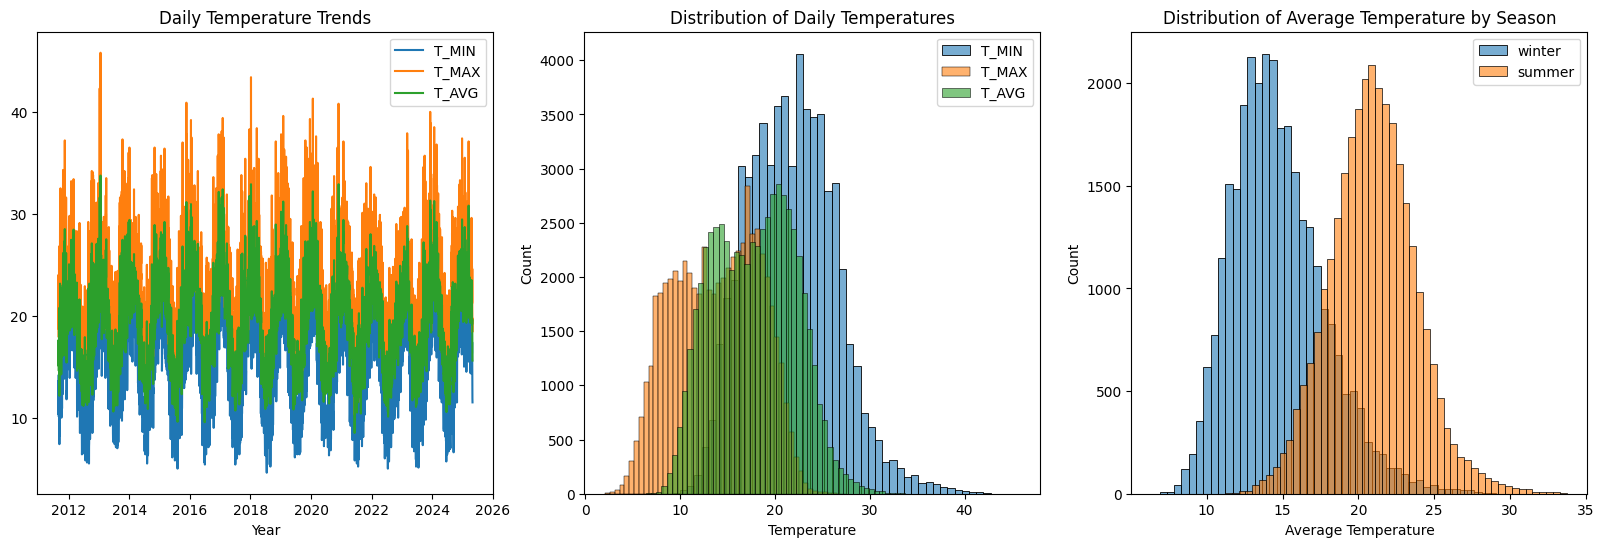

In [24]:
fig, axes = plt.subplots(ncols=3, figsize = (20,6))

#Looks normal with no anomalies
axes[0].set_title('Daily Temperature Trends')
axes[0].plot(df.iloc[-5000:, 0:3])
axes[0].set_xlabel('Year')
axes[0].legend(df.columns[0:3])

#Positive Skew for T_MIN, Broad Distribution for T_MAX, Broad Distribution with a Positive Skew for T_AVG
axes[1].set_title('Distribution of Daily Temperatures')
sns.histplot(data=df.T_MAX, alpha=0.6, bins=50, ax=axes[1])
sns.histplot(data=df.T_MIN, alpha=0.6, bins=50, ax=axes[1])
sns.histplot(data=df.T_AVG, alpha=0.6, bins=50, ax=axes[1])
axes[1].set_xlabel('Temperature')
axes[1].legend(df.columns[0:3])

#Positive Skew for Winter, Normal for Summer
axes[2].set_title('Distribution of Average Temperature by Season')
sns.histplot(data=df.loc[df['winter'] == 1, 'T_AVG'], alpha=0.6, bins=50, ax=axes[2])
sns.histplot(data=df.loc[df['summer'] == 1, 'T_AVG'], alpha=0.6, bins=50, ax=axes[2])
axes[2].set_xlabel('Average Temperature')
axes[2].legend(df.columns[-2:])

plt.show()

From the table below, we note the following:
- Highest and lowest monthly temperatures are 45.8 in Jan and 2.1 in Jun respectively.
- The gap between the maximum and minimum for both T_MIN and T_MAX is quite large.
- Temperature starts rising around the August period and starts dropping around Feb.

In [25]:
#Group by month and get the maximum and minimum for T_MAX and T_MIN
monthly_temps = df.loc[:, ['T_MIN', 'T_MAX', 'month']].groupby('month')
monthly_temps = monthly_temps.aggregate(['max', 'min'])

#Get Winter
mask = (monthly_temps.index >= 5) & (monthly_temps.index <= 10)
monthly_temps['winter'] = np.where(mask, 1, 0)
monthly_temps['summer'] = np.where(monthly_temps['winter'] != 1, 1, 0)
monthly_temps

T_MIN       T_MAX       winter summer
        max   min   max   min              
month                                      
1      26.2  10.6  45.8  17.2      0      1
2      27.6   9.6  42.1  15.6      0      1
3      25.4   9.3  39.8  16.2      0      1
4      24.3   7.0  35.4  13.8      0      1
5      20.8   4.4  30.0  11.3      1      0
6      18.4   2.1  26.9   9.7      1      0
7      18.1   2.2  26.5   7.7      1      0
8      19.7   2.7  31.3   9.1      1      0
9      23.0   4.9  34.6   9.5      1      0
10     25.6   5.7  38.2  12.1      1      0
11     25.3   7.7  41.8  12.6      0      1
12     27.1   9.1  42.2  15.2      0      1

For the rolling window period, we will use 10-years, which is within the commonly used 10~15 years.

We can observe a rising trend in average temperatures, indicating the presence of a trend component.

Meanwhile, the rolling variance shows that it is heteroskedastic (not constant) with some presence of a cycle with periodic rise and falls. There is also no clear trend and it is oscillating around a certain baseline. However, this could be due to overlapping windows or autocorrelated noise and testing has to be done to confirm these visuals.

Source: https://www.cmegroup.com/trading/weather/files/WEA_intro_to_weather_der.pdf

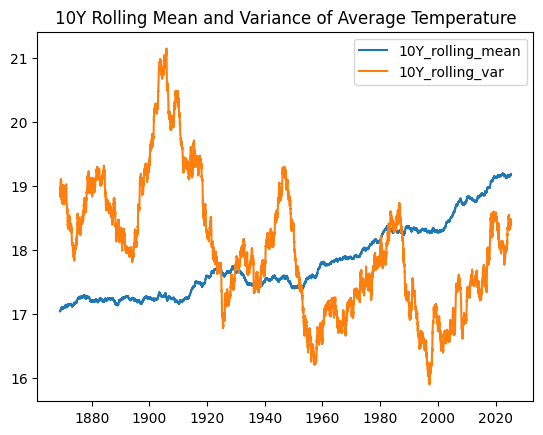

In [26]:
#Create 10-Year SMA and the Variance
rolling_window = 365*10
df['10Y_rolling_mean'] = df['T_AVG'].rolling(window=rolling_window).mean()
df['10Y_rolling_var'] = df['T_AVG'].rolling(window=rolling_window).var()

plt.title('10Y Rolling Mean and Variance of Average Temperature')
plt.plot(df['10Y_rolling_mean'])
plt.plot(df['10Y_rolling_var'])
plt.legend(df.columns[-2:])
plt.show()

## Time-Series Modelling and Analysis

In a time-series there are three main components:
1. Trend: Deterministic component.
2. Seasonal: Repeating short-term cycles in the data that occur at regular intervals.
3. Residual: Unexplained variability.

The simplest model is classical decomposition, which is a naive method. It assumes one of the following the two forms:

$$
\text{Additive Decomposition}: y_t = T_t + S_t + \epsilon_t \\
\text{Multiplicative Decomposition}: y_t = T_t* S_t* \epsilon_t
$$
where t is the timestamp, T is the Trend, S is the Seasonal and $\epsilon$ is the residual.

**Assumptions**:
- Seasonal component is constant and repeats identically over time.
- Components are independent of each other.
- Ignores autocorrelation in residuals.

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.

**Steps for Additive Decomposition**:
1. Compute $T_t$ using a centered moving average (to subsequently remove seasonality symmetrically) of N periods.
2. Calculate the de-trended series $y_t - T_t$.
3. Calculate $S_t$
    - Calculate $S_{index} = E[y_t - T_t]$. For example, with monthly data, the seasonal component for March is the average of all the detrended March values in the data.
    - Calculate $\bar{S} = E[S_{index}]$
    - Normalize $S_{normalize} = S_{index} - \bar{S}$
4. $\epsilon_t = y_t - T_t - S_t$

Source: 
- https://www.datacamp.com/tutorial/time-series-decomposition
- https://otexts.com/fpp3/components.html

Based on the recent 10-years time-series components, we have the following findings:
1. Extrapolation of the trend component can be significantly improved as we see that the linear assumption is flawed.
2. Clean pattern for the seasonal component.
3. Residuals are not completely random as there is still some pattern to it (autocorrelated noise), which further improvement in the model could remove.

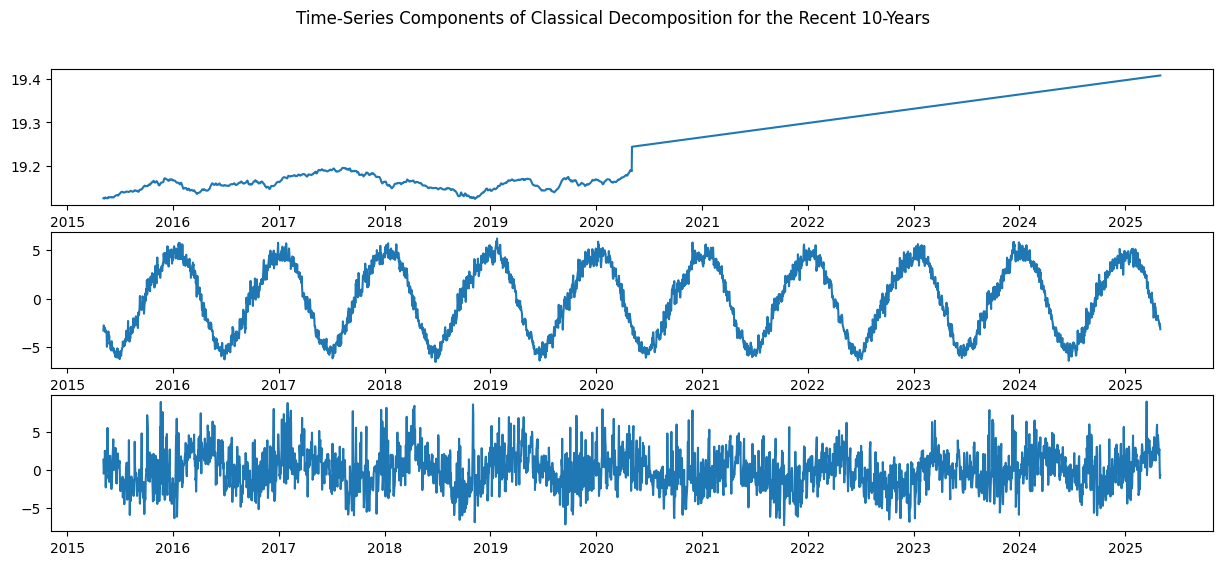

In [27]:
#Extrapolate the trend component and assumes linearity
classical_decompose = seasonal_decompose(df['T_AVG'], model='additive', period=rolling_window, extrapolate_trend='freq')
c_trend = classical_decompose.trend
c_seasonal = classical_decompose.seasonal
c_noise = classical_decompose.resid

#Visualize Last 10-Years
fig, axes = plt.subplots(nrows=3, figsize=(15,6))
fig.suptitle('Time-Series Components of Classical Decomposition for the Recent 10-Years')
axes[0].plot(c_trend[-rolling_window:])
axes[1].plot(c_seasonal[-rolling_window:])
axes[2].plot(c_noise[-rolling_window:])
plt.show()

### Residual Component
Ideally, we want out residuals to be stationary. Menawhile, trend and seasonality will definitely not be stationary in our case.

A stationary time series is one whose properties do not depend on the time at which the series is observed, where it does not matter when you observe it, it should look much the same at any point in time. In general, a stationary time series will have no predictable patterns in the long-term.

Stationarity is important as it ensures that the model will be stable with constant mean, variance and autocovariance. This makes the data more predictable as the underlying statistical remain constant over time, which is the main assumption of numerous time-series models like ARIMA. 

There are two methods to convert a non-stationary series to a stationary one:
1. Transformations such as logarithms can help to stabilise the variance of a time series. 
2. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series.

Source: 
- https://otexts.com/fpp2/stationarity.html
- https://maseconomics.com/why-stationarity-matters-in-time-series-econometrics/

Based on the ADF test results, we can reject the null hypothesis, which implies that the residual is likely to be stationary.

Other findings include:
- Strong evidence of stationarity (ADF test statistic is lower than the 1% and 5% critical values)
- Small number of lags as compared to our dataset length of 60753.

In [28]:
#H0: unit root exists (non-stationary)
def print_adfuller_result(series:pd.Series):
    test = adfuller(series, autolag='AIC')
    print(f'1. ADF: {test[0]:.4f}')
    print(f'2. p-value: {test[1]:.4f}')
    print(f'3. No. Lags: {test[2]}')
    print(f'4. No. Observations Used: {test[3]} or {test[3]/len(series):.2%}')
    print('5. Critical Values:')
    for key,val in test[4].items():
        print(f'\t {key}: {val:.4f}')

print_adfuller_result(c_noise)

1. ADF: -22.3363
2. p-value: 0.0000
3. No. Lags: 45
4. No. Observations Used: 60707 or 99.92%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


**A good forecasting method will yield residuals with the following properties**:
- Uncorrelated residuals: If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- Zero mean: If the residuals have a mean other than zero, then the forecasts are biased.

In order to check for the correlation between residuals, we can check using the two methods:
$$
\text{Autocorrelation Function (ACF)}: p_k = \frac{Cov(y_t, y_{t-k})}{V[y_t]} \\
\text{Partial ACF (PACF)}: y_t = \phi_t{y_{t-1}} + ... + \phi_k{y_{t-k}} + \epsilon_t
$$
where t is the current period, k is the time lag and $\phi_k$ is the PACF at lag k.

**Choosing the right model:**
- If the ACF demonstrates a spike and a sudden drop before leveling off over the time lag, then a MA model should be suitable.
- If the PACF demonstrates the above instead, then a AR model should be suitable.

**Residual Analysis:**

From the charts we can tell that:
1. Residual is normally distributed with a slight positive skew.
2. High autocorrelation that gradually decays over many lags, suggesting a strong persistence and that residuals are not white noise.
3. Strong spike at lag 1 and then near-zero afterwards indicating an AR(1) process.

Source: https://otexts.com/fpp2/residuals.html

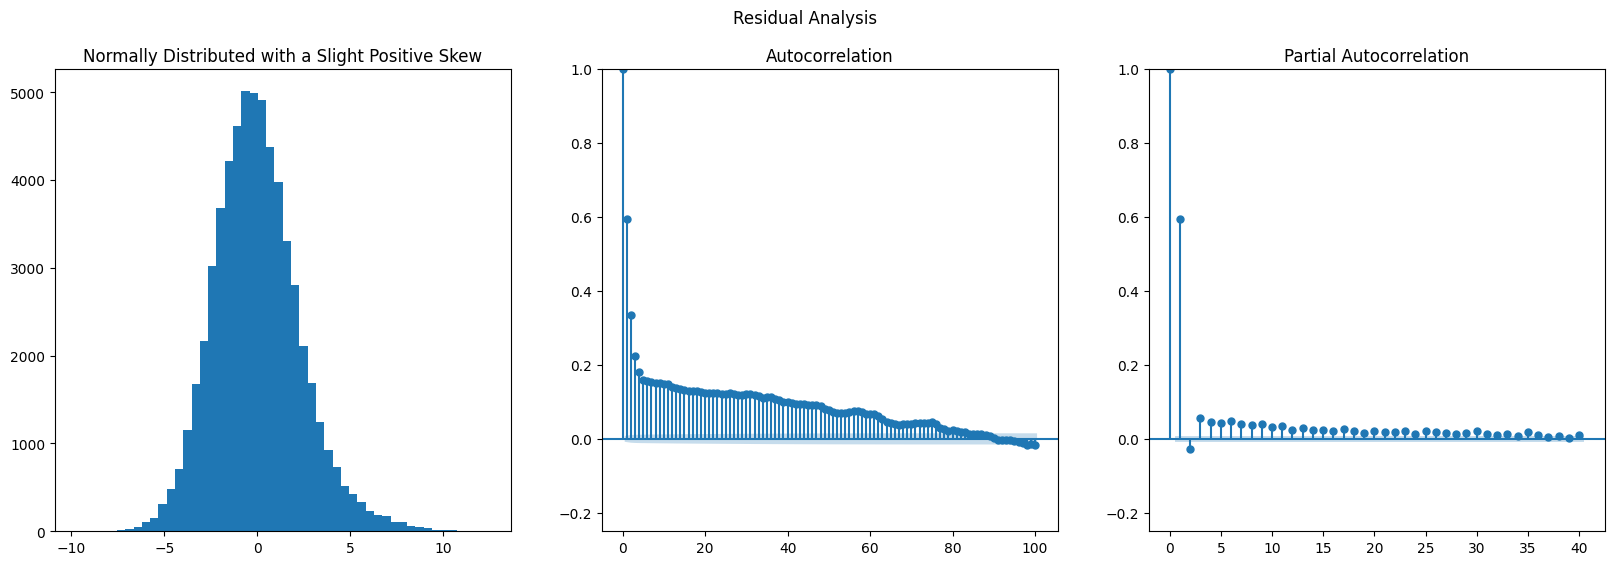

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('Residual Analysis')

axes[0].set_title('Normally Distributed with a Slight Positive Skew')
axes[0].hist(c_noise, bins=50)

plot_acf(c_noise, lags=100, ax=axes[1])
axes[1].set_ylim([-0.25, 1])

plot_pacf(c_noise, lags=40, ax=axes[2])
axes[2].set_ylim([-0.25, 1])

plt.show()

#### Akaike’s Information Criterion (AIC)

**About AIC**
While $R^2$ is widely used, it tends to be bias towards more predictor variables, leading to overfitting. Hence, we shall use AIC:
$$
\text{AIC} = T*ln(\frac{SSE}{T}) + 2(k+2)
$$
where T is the number of observations and k is the number of predictors.

The k+2 is due to k coefficients for the predictors, the intercept and the model varaince. The idea here is to penalise the fit of the model (SSE) with the number of parameters that need to be estimated. The model with the minimum value of the AIC is often the best model for forecasting.

If T is small (not in our case), then a bias-corrected version would be as follows:
$$
AIC_c = AIC + \frac{2(k+2)(k+3)}{T-k-3}
$$

**Selecting the right model**

After calculating the AIC scores,  we could either plot out the chart and select the elbow point for a simpler model or take the minimum of our scores. However after doing both methods, we can see that there is marginal improvement in the AIC score as the time lag gets bigger, hence the elbow method would be more suitable AR(14~17).

Source: https://otexts.com/fpp2/selecting-predictors.html

Best Lag: 40


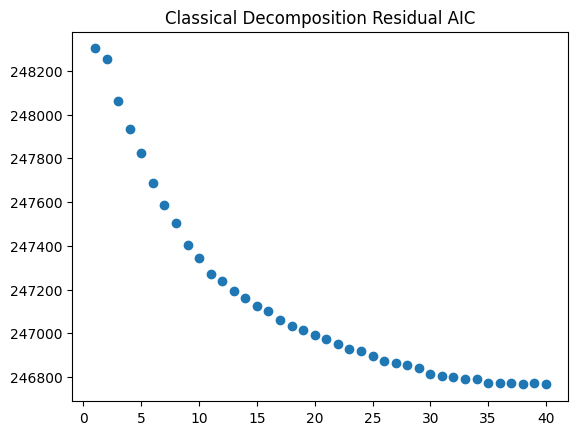

In [47]:
#Model Fitting
noise = c_noise.copy()
noise.index = noise.index.to_period('D') #For AIC calculation
aic_mod = ar_select_order(noise, maxlag=40, ic='aic') #Returns a tuple of lags and the score
c_aic = np.array([(key[-1], val) for key,val in aic_mod.aic.items() if key != 0])

#Minimum Method
min_aic_score_idx = np.argmin(c_aic[:, 1])
best_lag = c_aic[min_aic_score_idx, 0]
print(f'Best Lag: {int(best_lag)}')

#Elbow Method
plt.title("Classical Decomposition Residual AIC")
plt.scatter(c_aic[:, 0], c_aic[:, 1])
plt.show()

#### Analysis of Residual Model
Based on the results, we have a model with statistically significant coefficients. Though L12 have p-values above 0.05, the subsequent lags are significant and hence we leave it in and accept some noise. Though we could remove this lag specifically, the p-value of the other coefficients will change and some may no longer be statistically significant.

Based on the visualizations, we can also see that: 
- Residual resemble white noise and there is little to no ACF and PACF, fulfilling the conditions previously stated.
- Almost normally distributed with light tails at both ends.
- Symmetrically distributed and clustering towards the middle with no clear pattern.

After checking for skewness and kurtosis, we can also tell that it does have a slight positive skew and occasional large residuals.

In [48]:
chosen_lag = 15
noise.index = noise.index.to_timestamp() #Convert from 'D' period to timestamp
c_residual_ar_model = AutoReg(noise, lags=chosen_lag, trend='n').fit() #Constant has a p-value of 0.997, so it was removed.
print(c_residual_ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                60753
Model:                    AutoReg(15)   Log Likelihood             -123598.794
Method:               Conditional MLE   S.D. of innovations              1.852
Date:                Sun, 08 Jun 2025   AIC                         247229.588
Time:                        20:46:01   BIC                         247373.817
Sample:                    01-16-1859   HQIC                        247274.362
                         - 05-02-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid.L1       0.5961      0.004    146.961      0.000       0.588       0.604
resid.L2      -0.0671      0.005    -14.216      0.000      -0.076      -0.058
resid.L3       0.0238      0.005      5.042      0.0

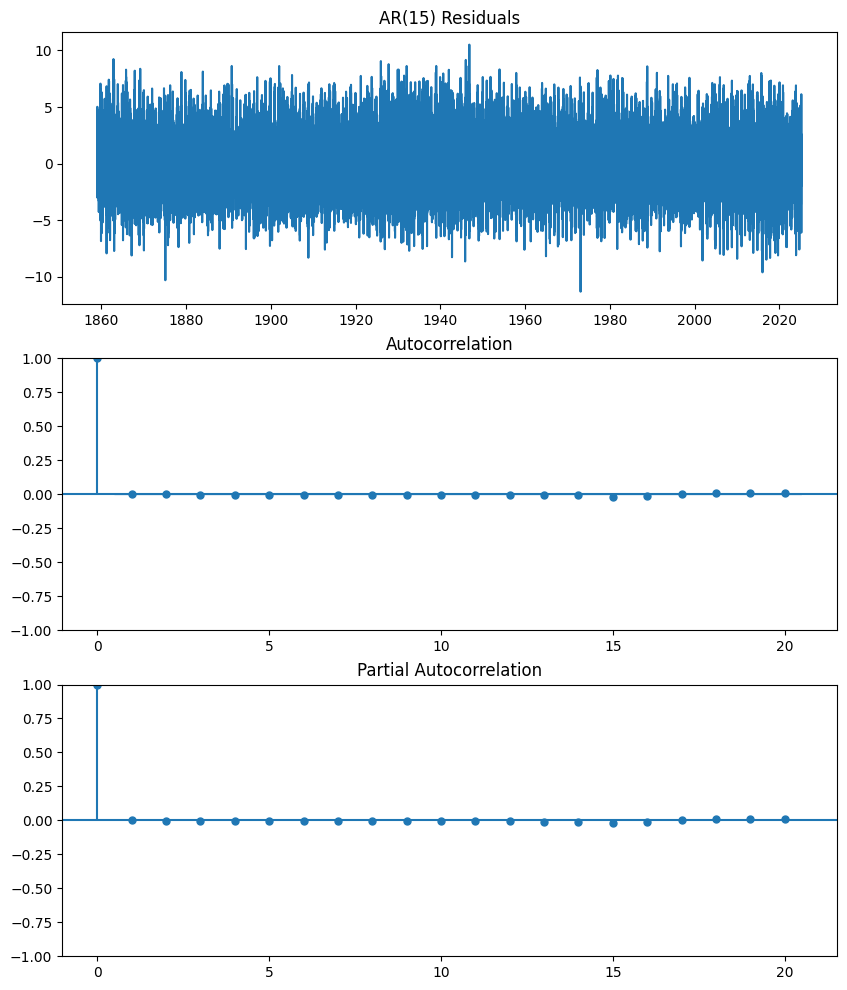

In [49]:
model_resid = c_residual_ar_model.resid

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('AR(15) Residuals')
axes[0].plot(model_resid)
plot_acf(model_resid, lags=20, ax=axes[1])
plot_pacf(model_resid, lags=20, ax=axes[2])
plt.show()

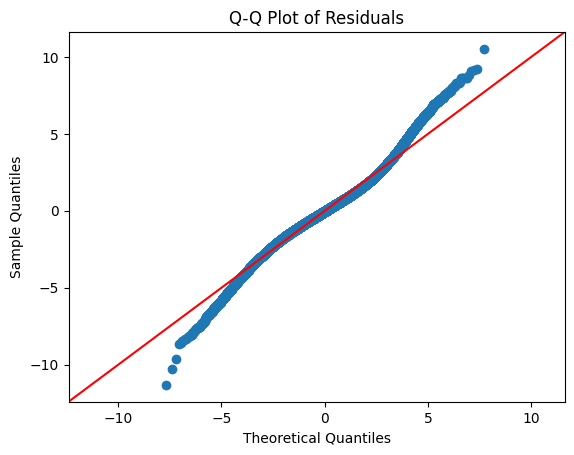

In [50]:
#Normally distributed, but skews near the ends
qqplot(model_resid, line='45', scale= np.std(model_resid))
plt.title('Q-Q Plot of Residuals')
plt.show()

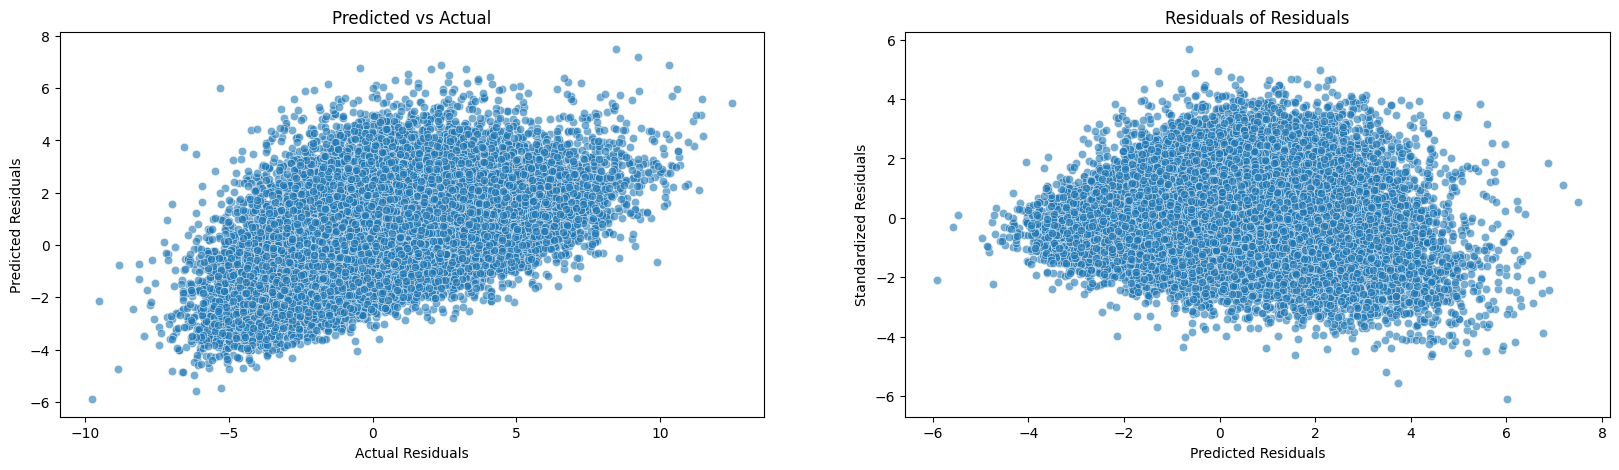

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

predicted_c_noise = c_residual_ar_model.fittedvalues
sns.scatterplot(x=c_noise[chosen_lag:], y=predicted_c_noise, alpha=0.6, ax=axes[0])
axes[0].set_title('Predicted vs Actual')
axes[0].set_xlabel('Actual Residuals')
axes[0].set_ylabel('Predicted Residuals')

scaled_model_resid = model_resid/np.std(model_resid)
sns.scatterplot(x=predicted_c_noise, y=scaled_model_resid, alpha=0.6, ax=axes[1])
axes[1].set_title('Residuals of Residuals')
axes[1].set_xlabel('Predicted Residuals')
axes[1].set_ylabel('Standardized Residuals')
plt.show()

In [52]:
print(f'Skewness: {skew(model_resid):.4f}')
print(f'Kurtosis: {kurtosis(model_resid, fisher=False):.4f}')

Skewness: 0.1888
Kurtosis: 4.6395


### Trend Component

Initially, we mentioned that a linear regression is not suitable for the trend component. Hence, we will dive deeper into how to properly model it. 

Based on the historical trend, we can see that the trend resembles a random walk with a deterministic drift:
- ACF is 1 for all lags, it means each value is almost perfectly correlated with previous values and definitely not a stationary process.
- PACF shows a spike at lag 1 and near-zero afterwards, implying a classic ARIMA(0, 1, 0) model.

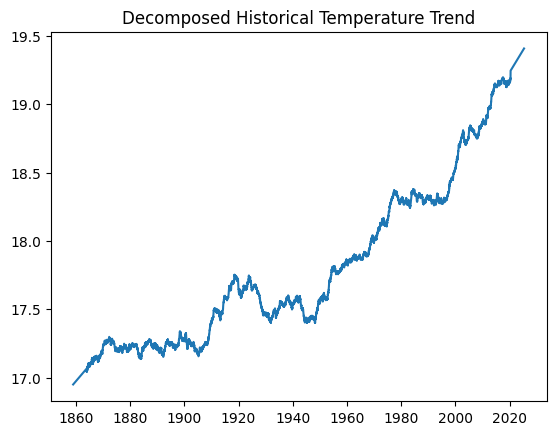

In [36]:
plt.plot(c_trend)
plt.title('Decomposed Historical Temperature Trend')
plt.show()

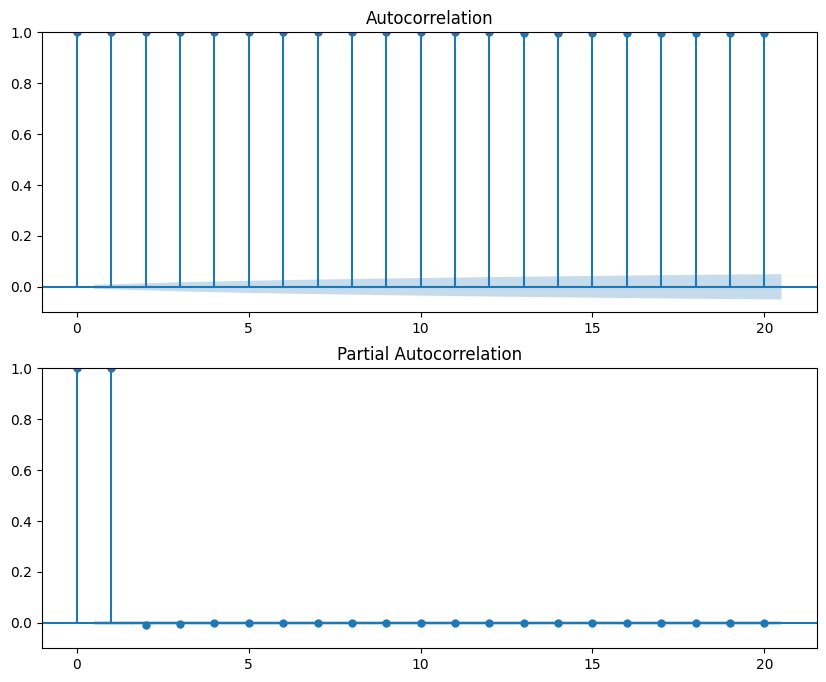

In [37]:
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
plot_acf(c_trend, lags=20, ax=axes[0])
axes[0].set_ylim([-0.1, 1])
plot_pacf(c_trend, lags=20, ax=axes[1])
axes[1].set_ylim([-0.1, 1])
plt.show()

#### About ARIMA

ARIMA stands for Auto Regressive Integrated Moving Average:
- AR: Lags of the time series' own past values as the regressors.
- I: Differencing of the time series component keeping in mind that our time series should be stationary.
- MA: Relationship between an observation and a residual error.

$$
y{^d_t} = AR(d) + MA(q) + c
$$

$$
AR(d) = \phi_1y{^d_{t-1}} + ... + \phi_py{^d_{t-p}}
$$

$$
MA(q) = \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}
$$
where p = AR order, d = degree of first differencing, q = MA order, c = constant

Source: 
- https://www.datacamp.com/tutorial/arima
- https://otexts.com/fpp2/non-seasonal-arima.html

In [38]:
#Check for stationarity
first_order_trend = c_trend.diff(periods=1)
print_adfuller_result(first_order_trend[1:])

1. ADF: -33.0882
2. p-value: 0.0000
3. No. Lags: 35
4. No. Observations Used: 60716 or 99.94%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


In our case, we want a ARIMA(0,1,0) model represented by the equation:

$$
y_t = y_{t-1} + \mu + \epsilon_t
$$
where $\epsilon_t - iid, N(0, \sigma^2)$

From where we stand, we know the past data points, so we can rearrange the terms to get the deterministic drift for that period:
$$
E[\triangle{y_t}] = E[\mu] + E[\epsilon_t] \\
E[\mu] = E[\triangle{y_t}] - 0 \\
\hat{\mu} = \frac{1}{T}\sum{\triangle{y_t}}
$$

In our case, after the first differencing, there is no longer that drift component so we expect $\mu = 0$

After we created the model, we note that the residuals are definitely not normally distributed with skew and kurtosis being way off normal.

In [39]:
c_trend.index = c_trend.index.to_period('D')
c_trend_arima = ARIMA(c_trend, order=(0,1,0)).fit() #No linear trend after first difference

print("Model Parameters:")
for key,val in c_trend_arima.params.items():
    print(f"{key}: {val}")
print(c_trend_arima.summary())

c:\Users\Finn_Nitro\Downloads\Quantitative Finance\Notebooks\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Parameters:
sigma2: 6.232291344484652e-07
                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                60753
Model:                 ARIMA(0, 1, 0)   Log Likelihood              347819.114
Date:                Tue, 03 Jun 2025   AIC                        -695636.228
Time:                        18:52:40   BIC                        -695627.214
Sample:                    01-01-1859   HQIC                       -695633.430
                         - 05-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.232e-07   2.42e-10   2576.078      0.000    6.23e-07    6.24e-07
Ljung-Box (L1) (Q):               28358.22   Jarque-Bera (JB):         482102239.89

#### Analysis of ARIMA Residuals

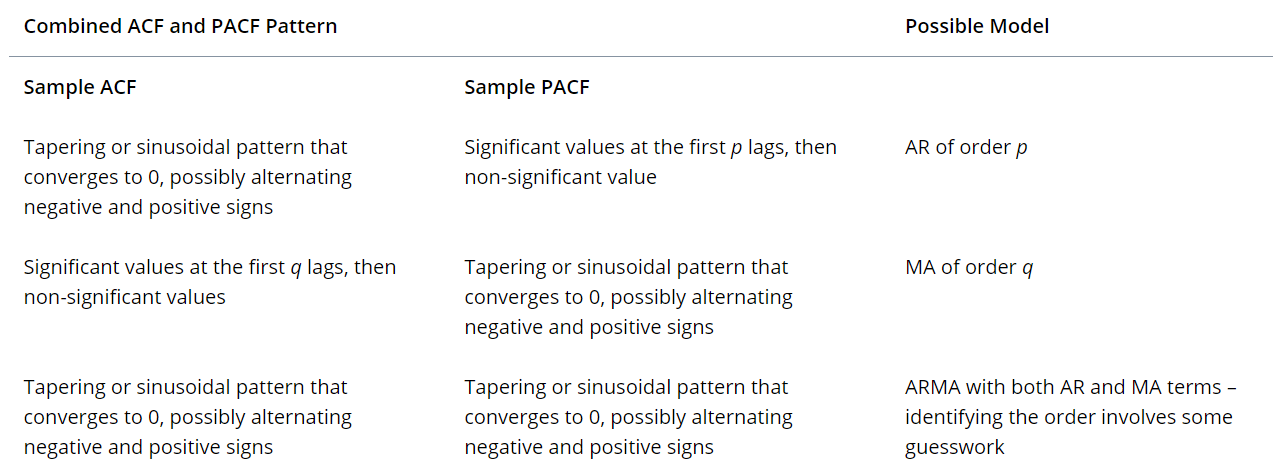

From the charts below, we see that there are 2 outliers on 31 Dec 1863 and 4 May 2020. Upon further digging, there was no clear reason for these outliers. Moreover, after removing the outliers and analyzing the residuals, we found that though the residuals are random, ACF is tapering and PACF is alternating. Hence, our model can be improved further by changing the orders of the AR and the MA.

Source: https://online.stat.psu.edu/stat510/lesson/14/14.1

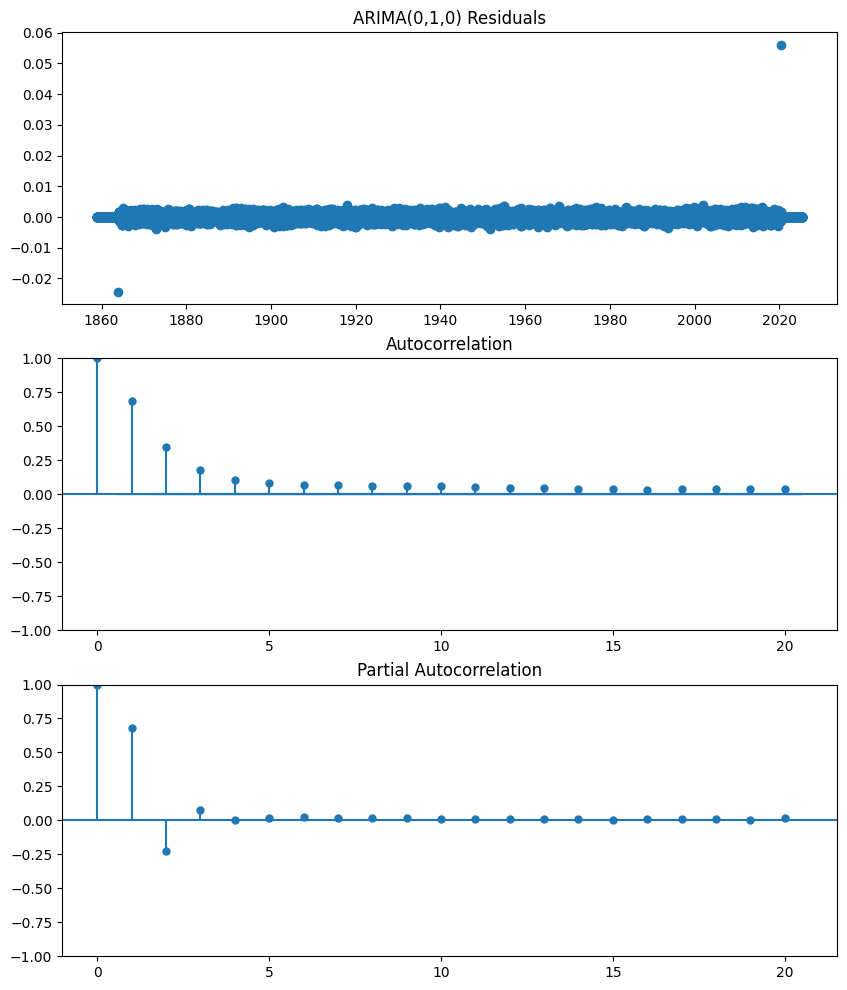

In [40]:
trend_resid = c_trend_arima.resid
trend_resid.index = trend_resid.index.to_timestamp()
trend_resid = trend_resid[1:] #First order differencing so there will be an initial spike, which we remove

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(0,1,0) Residuals')
axes[0].scatter(trend_resid.index,trend_resid.values)
plot_acf(trend_resid, lags=20, ax=axes[1])
plot_pacf(trend_resid, lags=20, ax=axes[2])
plt.show()

1863-12-31 00:00:00: 
17.042116438356164 vs 17.066433874434633

2020-05-04 00:00:00: 
19.244437444520678 vs 19.188321917808217


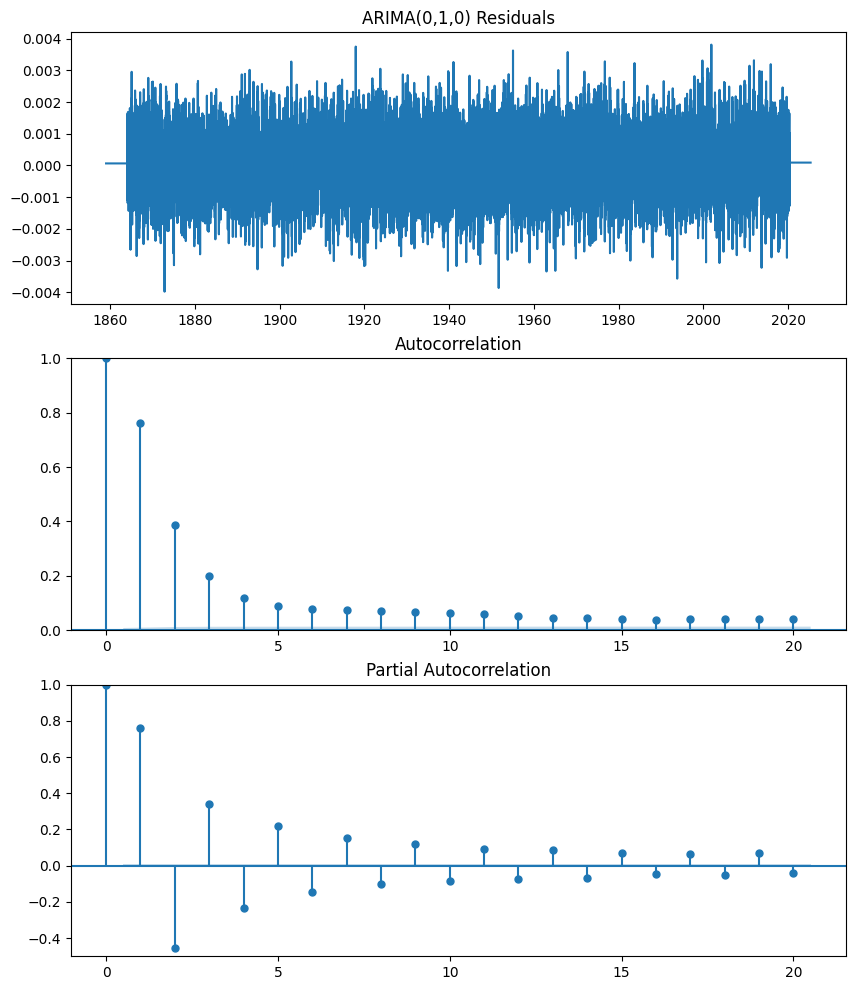

In [41]:
#Investigate Outliers
min_idx = trend_resid.index[np.argmin(trend_resid)]
max_idx = trend_resid.index[np.argmax(trend_resid)]

print(f'{min_idx}: \n{c_trend[min_idx]} vs {c_trend_arima.fittedvalues[min_idx]}\n')
print(f'{max_idx}: \n{c_trend[max_idx]} vs {c_trend_arima.fittedvalues[max_idx]}')

#Remove Outliers
no_outliers_residuals = trend_resid.copy()
no_outliers_residuals = no_outliers_residuals.drop([min_idx, max_idx], axis='index')

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(0,1,0) Residuals')
axes[0].plot(no_outliers_residuals) #First order differencing so there will be an initial spike, which we remove
plot_acf(no_outliers_residuals, lags=20, ax=axes[1])
axes[1].set_ylim([0, 1])
plot_pacf(no_outliers_residuals, lags=20, ax=axes[2])
axes[2].set_ylim([-0.5,1])
plt.show()

#### Model Improvement

Given the condition of our PACF and ACF, it is likely that we need both the AR and MA component to be included in our model. Since the grid search led to MLE convergence failures and extremely slow optimization, we shall scale the data to a standard normal distribution for efficiency. Of which, we got the best AR and MA terms to be 2 and 3 respectively. 

However, we have to be cautious that an AR term and an MA term could cancel each other's effects, so we try a model with one fewer AR term and one fewer MA iteratively and select the best model from there. ARIMA(2,1,3) and ARIMA(1,1,2) both have coefficients that are all statistically significant. The residual distribution is random and the ACF and PACF charts shows no further notable autocorrelations. Hence, we shall opt for the simpler model ARIMA(1,1,2). 

Source: https://people.duke.edu/%7Ernau/411arim3.htm#plots

In [156]:
no_outlier_trend = first_order_trend[1:].copy()
no_outlier_trend.loc[[min_idx, max_idx]] = np.nan
no_outlier_trend = impute_missing_values(no_outlier_trend)
trend_mean = no_outlier_trend.mean()
trend_std = np.std(no_outlier_trend)

#Scale Data
scaled_no_outlier_trend = (no_outlier_trend - trend_mean)/ trend_std #Scaled to allow for better convergence on Maximum Likelihood
print_adfuller_result(no_outlier_trend)

1. ADF: -25.2618
2. p-value: 0.0000
3. No. Lags: 60
4. No. Observations Used: 60691 or 99.90%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


In [43]:
#Model Fitting
chosen_lag = 3
aic_mod = arma_order_select_ic(scaled_no_outlier_trend, max_ar=chosen_lag, max_ma=chosen_lag, ic='aic', trend='n',) #Tuple of p, df[index = q, val = AIC]

# Minimum Method
print(f'Best Lag: {aic_mod.aic_min_order}')

c:\Users\Finn_Nitro\Downloads\Quantitative Finance\Notebooks\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Finn_Nitro\Downloads\Quantitative Finance\Notebooks\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Finn_Nitro\Downloads\Quantitative Finance\Notebooks\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best Lag: (np.int64(2), np.int64(3))


In [44]:
scaled_no_outlier_trend.index = scaled_no_outlier_trend.index.to_period('D')
best_arima = ARIMA(scaled_no_outlier_trend, order=(2,0,3), trend='n').fit() #Exclude difference as we put in the differenced data, removed constant as p>0.05

print("Model Parameters:")
for key,val in best_arima.params.items():
    print(f"{key}: {val}")
print(best_arima.summary())

Model Parameters:
ar.L1: 1.3978494185370558
ar.L2: -0.40933604726489986
ma.L1: 0.1664613656819166
ma.L2: -0.9482324305803207
ma.L3: -0.14043465988219356
sigma2: 0.22721609118352332
                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                60750
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -41191.293
Date:                Tue, 03 Jun 2025   AIC                          82394.585
Time:                        18:58:58   BIC                          82448.672
Sample:                    01-02-1859   HQIC                         82411.376
                         - 05-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3978      0.

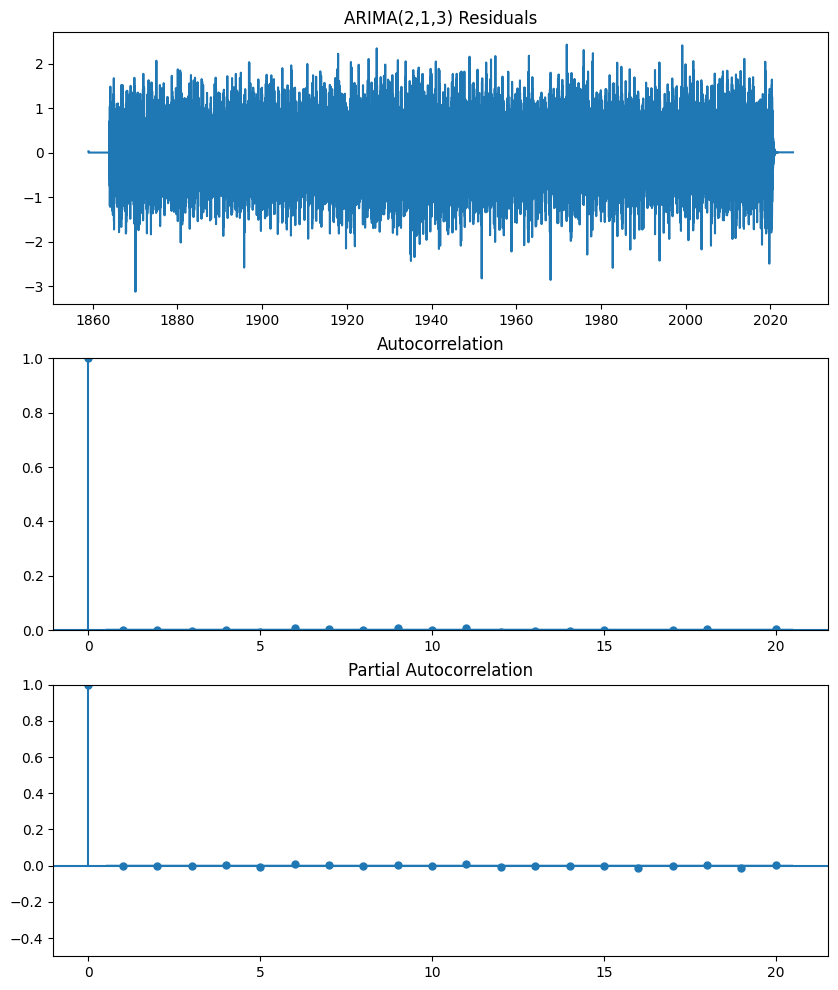

In [45]:
resid = best_arima.resid
resid.index = resid.index.to_timestamp()

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(2,1,3) Residuals')
axes[0].plot(resid)
plot_acf(resid, lags=20, ax=axes[1])
axes[1].set_ylim([0, 1])
plot_pacf(resid, lags=20, ax=axes[2])
axes[2].set_ylim([-0.5,1])
plt.show()

In [46]:
best_arima = ARIMA(scaled_no_outlier_trend, order=(1,0,2), trend='n').fit() #Try lowering each order to see if any cancelled each other out and are not necessary
print("Model Parameters:")
for key,val in best_arima.params.items():
    print(f"{key}: {val}")
print(best_arima.summary())

Model Parameters:
ar.L1: 0.46618791338137067
ma.L1: 1.1032322578984608
ma.L2: 0.11652648312873246
sigma2: 0.22816319637220261
                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                60750
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -41318.580
Date:                Tue, 03 Jun 2025   AIC                          82645.160
Time:                        18:59:58   BIC                          82681.218
Sample:                    01-02-1859   HQIC                         82656.354
                         - 05-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4662      0.006     82.232      0.000       0.455       0.477
ma.L1

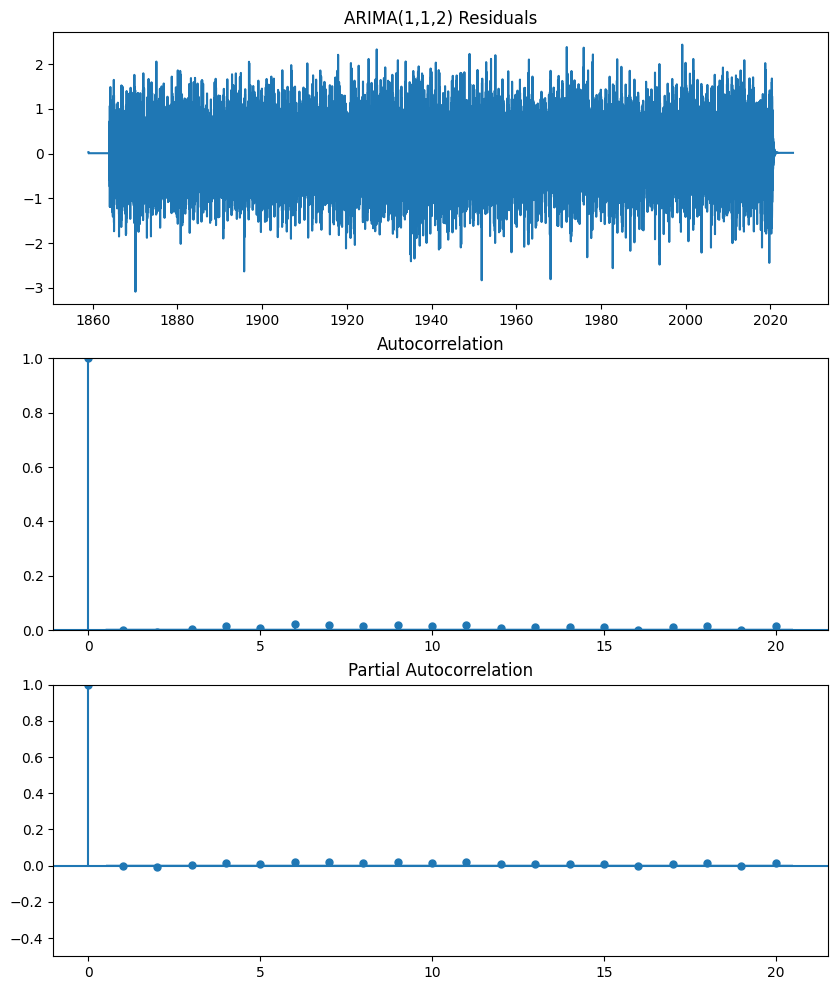

In [47]:
resid = best_arima.resid
resid.index = resid.index.to_timestamp()

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(1,1,2) Residuals')
axes[0].plot(resid)
plot_acf(resid, lags=20, ax=axes[1])
axes[1].set_ylim([0, 1])
plot_pacf(resid, lags=20, ax=axes[2])
axes[2].set_ylim([-0.5,1])
plt.show()

In [48]:
best_arima = ARIMA(scaled_no_outlier_trend, order=(0,0,1), trend='n').fit() #Try lowering each order to see if any cancelled each other out and are not necessary
print("Model Parameters:")
for key,val in best_arima.params.items():
    print(f"{key}: {val}")
print(best_arima.summary())

c:\Users\Finn_Nitro\Downloads\Quantitative Finance\Notebooks\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model Parameters:
ma.L1: 0.994182836425984
sigma2: 0.32612007685077554
                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                60750
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -52168.424
Date:                Tue, 03 Jun 2025   AIC                         104340.848
Time:                        19:01:06   BIC                         104358.877
Sample:                    01-02-1859   HQIC                        104346.445
                         - 05-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9942      0.001   1668.243      0.000       0.993       0.995
sigma2         0.3261      0.002    215.304      0.000      

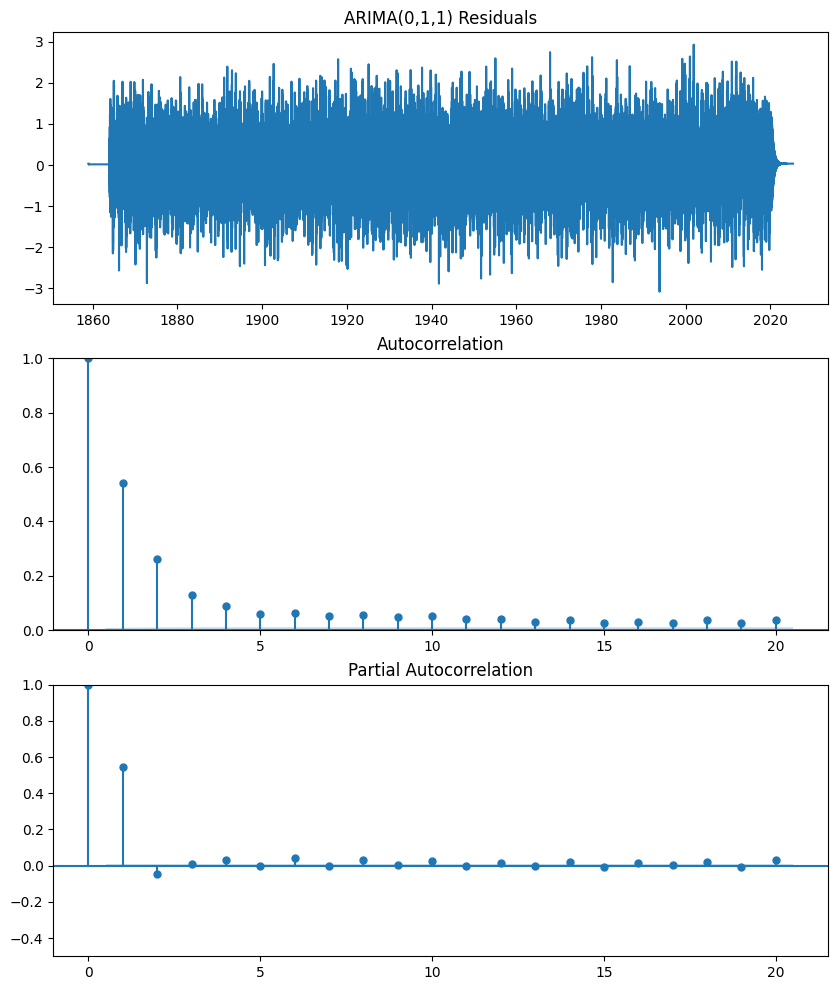

In [49]:
resid = best_arima.resid
resid.index = resid.index.to_timestamp()

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(0,1,1) Residuals')
axes[0].plot(resid)
plot_acf(resid, lags=20, ax=axes[1])
axes[1].set_ylim([0, 1])
plot_pacf(resid, lags=20, ax=axes[2])
axes[2].set_ylim([-0.5,1])
plt.show()

In [50]:
best_arima = ARIMA(scaled_no_outlier_trend, order=(1,0,0), trend='n').fit() #Try lowering each order to see if any cancelled each other out and are not necessary
print("Model Parameters:")
for key,val in best_arima.params.items():
    print(f"{key}: {val}")
print(best_arima.summary())

Model Parameters:
ar.L1: 0.7606071080758967
sigma2: 0.42148037838902236
                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                60750
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -59957.228
Date:                Tue, 03 Jun 2025   AIC                         119918.457
Time:                        19:01:54   BIC                         119936.486
Sample:                    01-02-1859   HQIC                        119924.053
                         - 05-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7606      0.002    333.595      0.000       0.756       0.765
sigma2         0.4215      0.002    221.703      0.000     

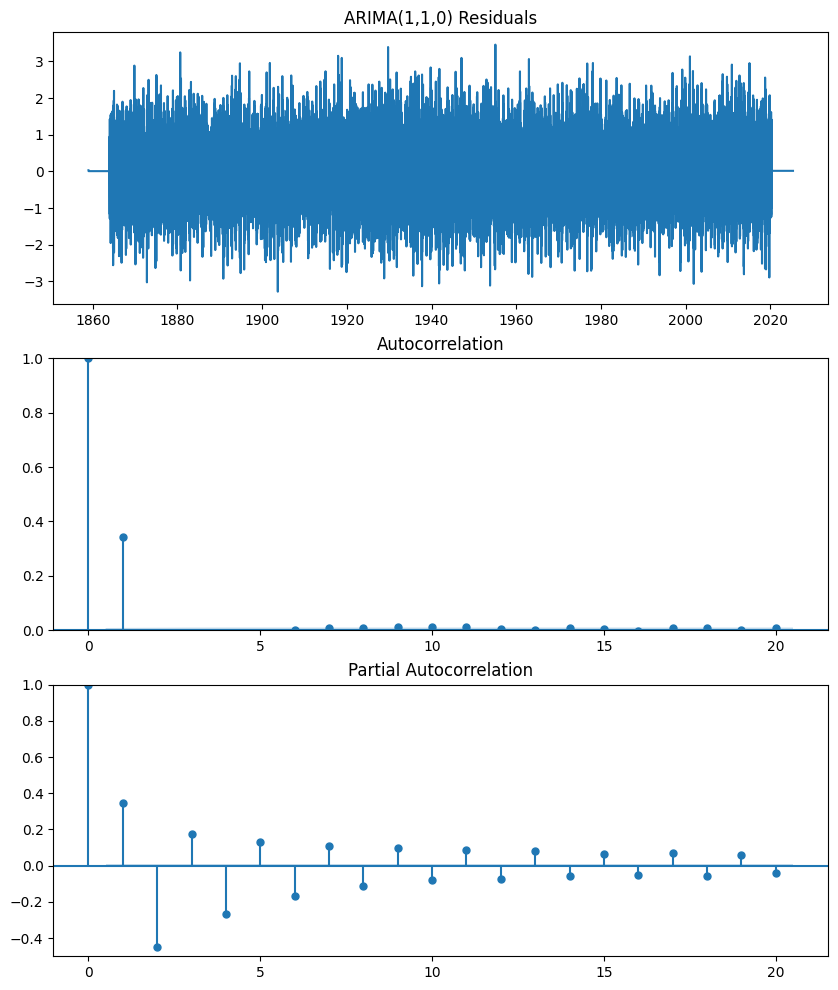

In [51]:
resid = best_arima.resid
resid.index = resid.index.to_timestamp()

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(1,1,0) Residuals')
axes[0].plot(resid)
plot_acf(resid, lags=20, ax=axes[1])
axes[1].set_ylim([0, 1])
plot_pacf(resid, lags=20, ax=axes[2])
axes[2].set_ylim([-0.5,1])
plt.show()

#### Analysis of Chosen Model Residual

Based on the visualizations, we can see that: 
- Residual resemble white noise and there is little to no ACF and PACF.
- Heavy-tailed on the left and light-tailed on the right.
- Symmetrically distributed and clustering towards the middle with no clear pattern.

After checking for skewness and kurtosis, we can also tell that it does have a slight negative skew and occasional large residuals.

Overall, ARIMA(1,1,2) results are satisfactory.

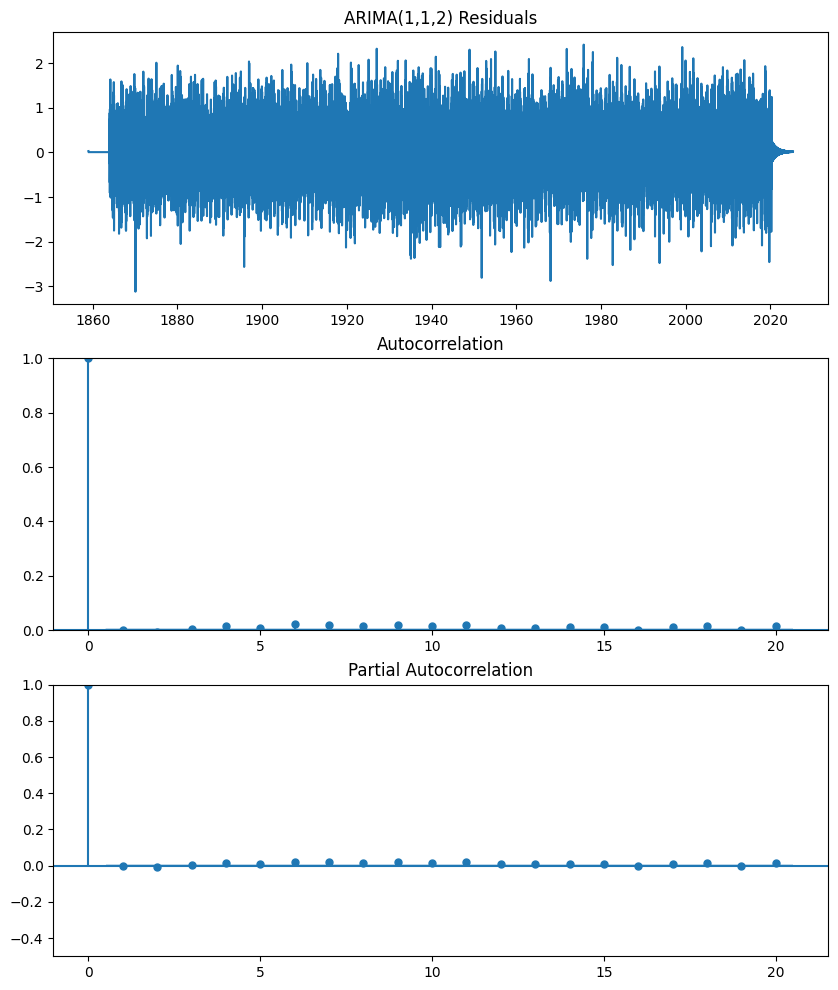

In [158]:
best_arima = ARIMA(scaled_no_outlier_trend, order=(1,0,2), trend='n').fit()
resid = best_arima.resid
resid.index = resid.index.to_timestamp()

fig, axes = plt.subplots(nrows=3, figsize=(10,12))
axes[0].set_title('ARIMA(1,1,2) Residuals')
axes[0].plot(resid)
plot_acf(resid, lags=20, ax=axes[1])
axes[1].set_ylim([0, 1])
plot_pacf(resid, lags=20, ax=axes[2])
axes[2].set_ylim([-0.5,1])
plt.show()

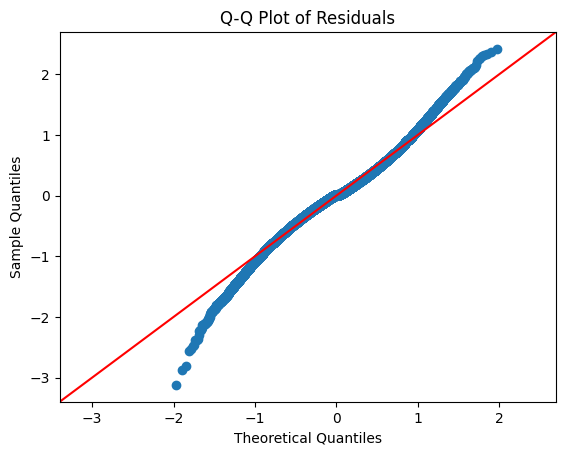

In [159]:
#Heavy Tailed
qqplot(resid, line='45', scale=np.std(resid))
plt.title('Q-Q Plot of Residuals')
plt.show()

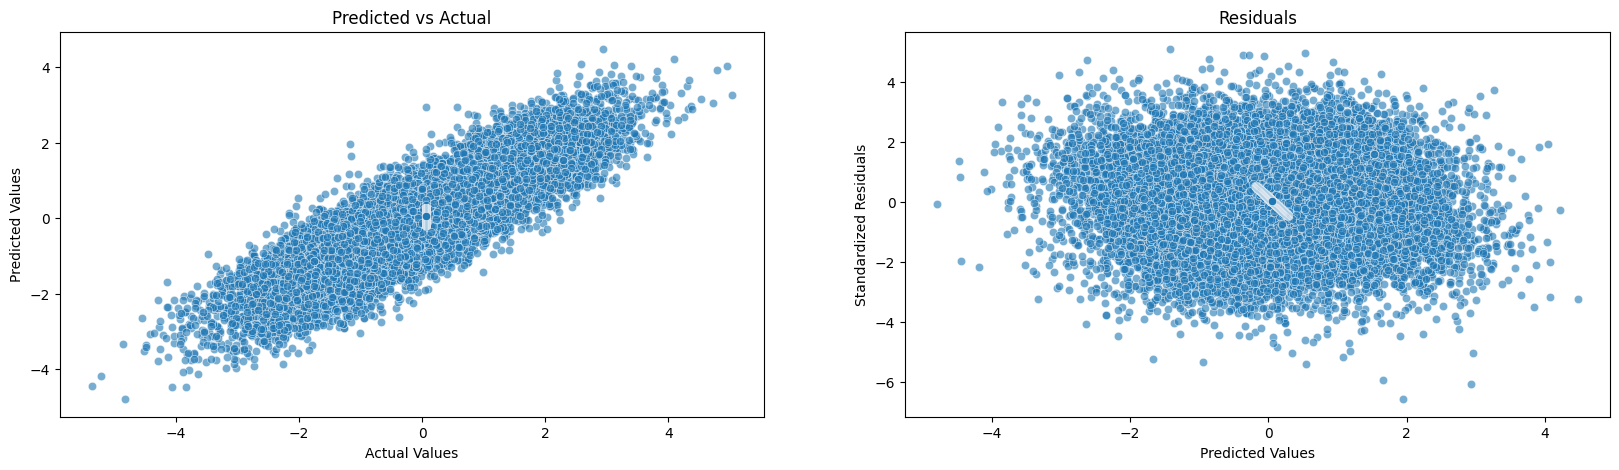

In [160]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

#Vertical line of points is due to linear extrapolation from classical decomposition
predicted_c_trend = best_arima.fittedvalues
sns.scatterplot(x=scaled_no_outlier_trend, y=predicted_c_trend, alpha=0.6, ax=axes[0])
axes[0].set_title('Predicted vs Actual')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')

#Diagonal line of points is due to linear extrapolation from classical decomposition
scaled_model_resid = resid/np.std(resid)
scaled_model_resid.index = scaled_model_resid.index.to_period('D')
sns.scatterplot(x=predicted_c_trend, y=scaled_model_resid, alpha=0.6, ax=axes[1])
axes[1].set_title('Residuals')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Standardized Residuals')
plt.show()

In [161]:
#Normally distributed
print(f'Skewness: {skew(resid):.4f}')
print(f'Kurtosis: {kurtosis(resid, fisher=False):.4f}')

Skewness: -0.0216
Kurtosis: 4.4483


### Seasonality Component

#### What is a Signal?
In signal processing, a signal refers to information that we are interested in or a function (typically of time) that conveys information.
- Signal processing allows us to extract valuable insights from this raw data that might not be apparent at first glance.
- Continuous signals $x(t)$ have values for all points in time, while discrete signals $x[n]$ only have values at specific, distinct time points. 

**Time and Frequency Domains**

There are two domains for signals that can be converted from one to another using Discrete Fourier Transform (DFT):
1. Discrete Time Domain $x[n]$: How we naturally look at time series. “What is the temperature on day 12?".
2. Frequency Domain $X[n]$: How the signal's energy is distributed over a range of frequencies. “How much of this signal is made of weekly patterns? Daily fluctuations? Random noise?”

The frequency domain is further broken down into real $\text{Re} X[n]$ and imaginary $\text{Im} X[n]$, which are the amplitudes of the cosine and sine waves respectively. In our case, we notice that our seasonal component demonstrates clear periodic patterns, which implies there is strong frequency-domain information embedded in it.

Based on the seasonal component chart of the last 10 years, we can see that our seasons are not smooth and contain alot of noise. We want to remove these noise to ensure that our model is not overfitting to noise and improve overall predictive performance. There are numerous ways to smoothen out the seasonal component, such as:
1. Moving Average - Time Domain Smoothing where you just want a smoother signal without diving into its frequency content.
2. Smoothing Filters - Frequency Domain Smoothing where you want to keep/remove specific cycles. It breaks the signal into frequencies, then removes or keeps certain ones,

Source: 
- https://www.datacamp.com/tutorial/a-data-scientists-guide-to-signal-processing
- https://www.mathworks.com/help/signal/ug/practical-introduction-to-frequency-domain-analysis.html
- https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch8.pdf
- https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch14.pdf

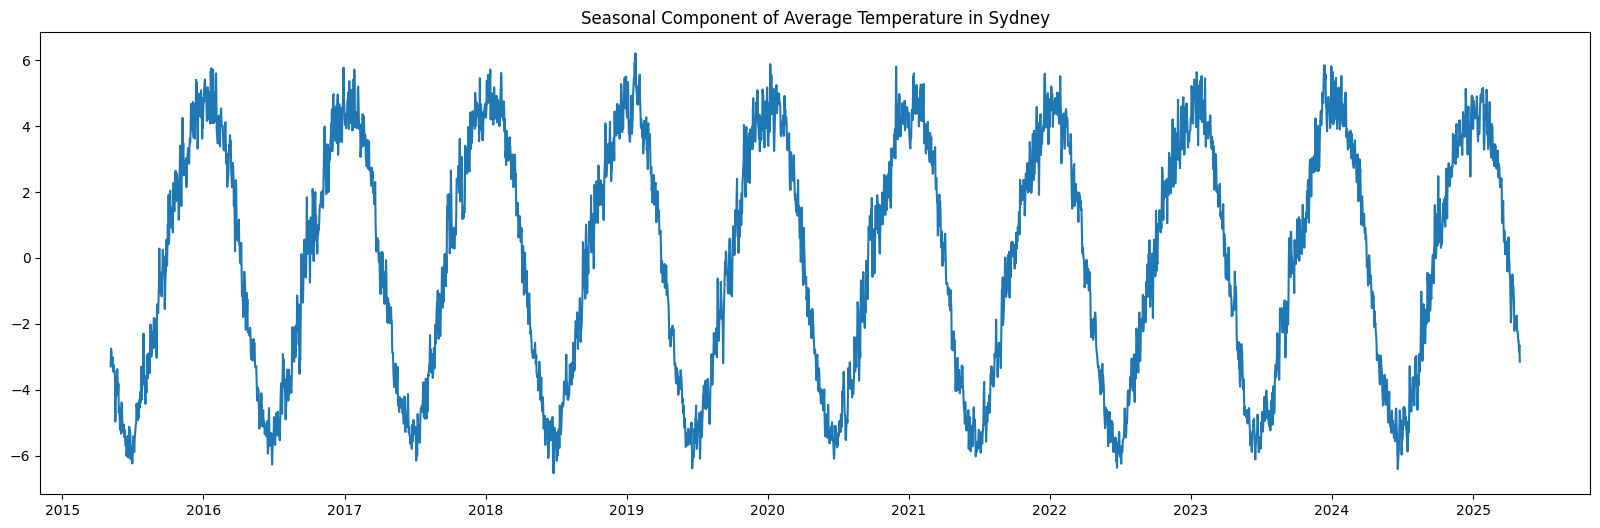

In [56]:
plt.figure(figsize=(20,6))
plt.plot(c_seasonal[-rolling_window:])
plt.title('Seasonal Component of Average Temperature in Sydney')
plt.show()

#### Denoise Seasonality

**About Fourier Transform**

Imagine that we have an audio that consists of three instruments, we can represent it as:
$$
x(t) = s_1(t) + s_2(t) + s_3(t) + \epsilon_t
$$
where $s_i$ are the instruments and $\epsilon_t$ is noise.

The problem is how do we break down $x(t)$ into the pure frequencies that make it up, which Fourier Transform seeks to address. The core idea is that important signal components appear as spikes (peaks) in the frequency domain, while noise often appears as small, scattered values across a wide range of frequencies, typically near-zero. For an in-depth explanation of the process, refer to the Youtube link below.

The conversion from time to frequency can be expressed as:
$$
X(f) = \frac{1}{t_2 - t_1}\int\limits_{t_1}^{t_2}x(t)e^{-2\pi ift}dt
$$
where $t$ is time, $i$ is the imaginary part and $f$ is the frequency ($f = \frac{1}{T}$ where $T$ is sampling period or daily in our case).

However as the typical notation is to go to infinity, we get:
$$
X(f) = \int\limits_{-\infty}^{\infty}x(t)e^{-2\pi ift}dt
$$

Meanwhile the inverse fourier transform from frequency to time is denoted as:
$$
x(t) = \int\limits_{-\infty}^{\infty}X(f)e^{2\pi ift}df
$$

Source: https://www.youtube.com/watch?v=spUNpyF58BY

**Application**

In our case, we will use the Fast Fourier Transform (FFT) algorithm - speeds up the calculation process through a divide and conquer approach, to convert our series into the frequency domain and filter out the noise before converting back to the time domain. 

Based on the frequency domain representation, we can see two distinct spikes suggesting that there is likely two dominant periodic cycles, one at about 0.00275 and the other twice that at around 0.0055, which indicates the presence of an annual (every 365.25 days) and a semi-annual cycle (every 181 days). 

- For the annual cycle, it makes sense as it takes approximately 365.25 days for the Earth to orbit the Sun. Hence if we take $\frac{1}{365.25}$, we will get 0.0027. 
- However, the semi-annual cycle is interesting and could be attributed to the transition period between the four seasons.

Source: https://spaceplace.nasa.gov/leap-year/en/

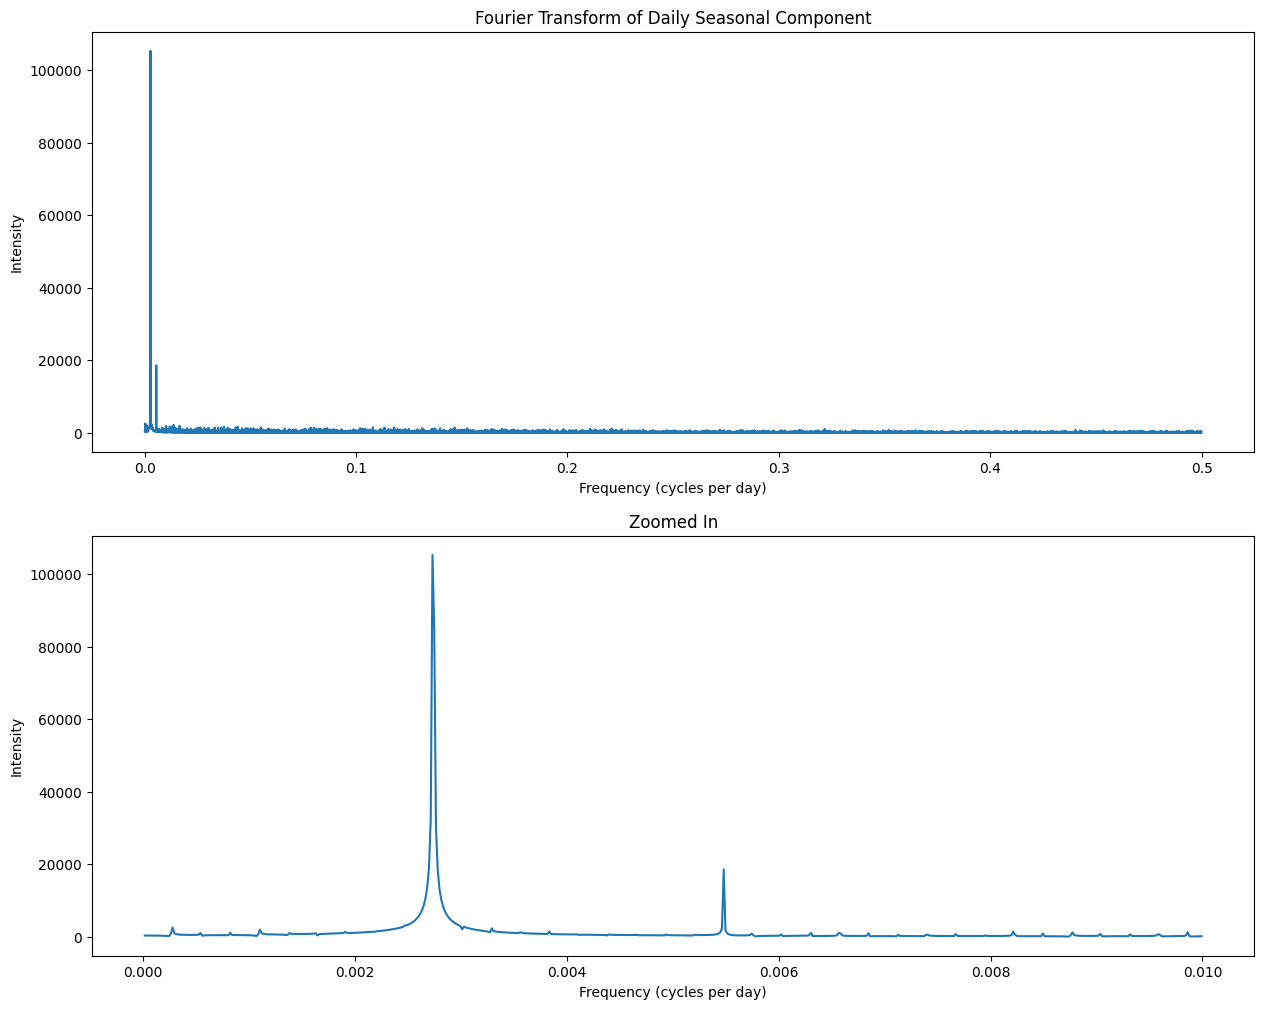

In [57]:
n = len(c_seasonal)
daily_interval = 1
x = c_seasonal.values

X = fft(x)
f = fftfreq(n, daily_interval)

fig, axes = plt.subplots(nrows=2, figsize=(15,12))

idx = np.where(f > 0) #Symmetric on both ends, so we only need the positive end
mask_x, mask_y = f[idx], X[idx]
axes[0].set_title("Fourier Transform of Daily Seasonal Component")
axes[0].set_xlabel("Frequency (cycles per day)")
axes[0].set_ylabel("Intensity")
axes[0].plot(mask_x, np.abs(mask_y)) #np.abs to address complex numbers by getting its magnitude

#Zoom In
idx = np.where(mask_x < 0.01)
mask_x, mask_y = mask_x[idx], mask_y[idx]
axes[1].set_title("Zoomed In")
axes[1].set_xlabel("Frequency (cycles per day)")
axes[1].set_ylabel("Intensity")
axes[1].plot(mask_x, np.abs(mask_y)) #np.abs to address complex numbers by getting its magnitude

plt.show()

**Smoothing Our Seasonality Component**

There are two basic types of filters, a low-pass and a high-pass filter that allows low frequencies and high frequencies to pass respectively. Based on our case, we want a combination of the two, known as a band-pass filter that consists of a high-pass filter for frequencies above 0.0024 and a low-pass filter for the ones below 0.0056. Consequently, this will keep the core signal components and smooth out our seasonal component.

We will implement three filters and compare the results to select the best one:
1. **Ideal Band-Pass Filter** - A brick wall that is strict and only allow frequencies within the specified band to pass.
2. **Butterworth Band-Pass Filter** - Similar to the ideal band-pass filter, but instead of a brick wall, it transitions gradually from “fully passed” to “fully blocked”. 
3. **Simple Convolution** - A baseline filter that uses a 90-days rolling window.

##### About Butterworth
Before diving into Butterworth, below are some simplified key definitions to know:
- **Attenuation**: Reduction in the amplitude of a signal as it travels through a medium.
- **Infinite Impulse Response (IIR)**: Infinite sum of decaying exponentials that never goes to 0, which provides the smooth transition band.
- **Phase Response**: Describes how much each frequency component is shifted in time by the filter.
- **Ripples**: Tiny oscillations in the passband or stopband of a filter’s frequency response. They show up as periodic up-and-down wiggles instead of a smooth curve.
- **Ringing**: When a filter has an abrupt frequency cutoff (like an ideal brick-wall or a high-order filter), the signal oscillates for a while before settling in the time-domain.

The Butterworth filter is the best compromise between attenuation and phase response: 
- **Maximially Flat Filter**: Minimal to no ripples in the pass band or the stop band, however this comes with a relatively wide transition region controlled by the filter-order.
- **Feedback Structure**: Computationally more efficient as it essentially "re-uses" values to compute the IIR.
- **Reduce Ringing**: A gradual “roll-off” rather than a brick-wall cutoff, so noise is only partially attenuated rather than completely removed.

However, there are limitations:
- **Treats every year the same**: If your seasonal amplitude or timing drifts slowly over decades, a fixed-parameter IIR can misalign or under/over-smooth parts of the series.
- **Heteroskedastic Residuals**: In climates with uneven season length or variability (like a long, plateaued summer), that can show up as systematic bias in your anomalies.

For the complex math behind how and why it works, refer to the ScienceDirect link below.

##### About Convolution
$$
(f*g)(t)= \int^{\infty}_{-\infty}f(x)g(x-\tau)d\tau
$$

Convolution is a mathematical operation which generates a new function $(f*g)(x)$ that is a function of two prior functions $f(x)$ and $g(x)$. It is the area under the curve of two functions which are moved towards and then away from one another ("convolved"). Essentially, it is about combining two different results and combining them to find their cumulative result. 

In our case, we will convolve a 90-days rolling window as anything above that value will exclude too much information and anything below will keep too much noise. Moreover, this value also captures the annual and semi-annual cycle components as $\frac{1}{90}$ is approximately 0.0111 cycles per day. In order to ensure that the convolved result is the same length as our seasonal data, we use zero-padding on both ends and use the central part of the full convolution. 

However, this comes with limitations:
- **Slightly distorted peaks and troughs**: Hot summer peaks get pulled down more at the very edges, and cold troughs pulled up, simply because part of the window is empty.
- **Bias towards the mean**: Near the start and end, you effectively have fewer real samples in the window, which drags the result towards the mean.

Source: 
- https://www.kaggle.com/code/residentmario/denoising-algorithms
- https://dsp.stackexchange.com/questions/89984/what-is-the-rationale-behind-the-same-mode-of-discrete-convolution
- https://www.sciencedirect.com/topics/engineering/butterworth-filter

In [58]:
class SeasonalSmooth:
    def __init__(self, data:pd.Series, daily_interval=1):
        self.data = data.copy()
        self.daily_interval = daily_interval
        self.fast_fourier_transform(self.daily_interval)
        
    def fast_fourier_transform(self, daily_interval=1, freq_domain:bool=True, X=None) -> pd.Series:
        if freq_domain:
            n = len(self.data)
            self.X = fft(self.data.values)
            self.freq = fftfreq(n, daily_interval)
        
        else:
            target = self.X if X is None else X
            self.x = ifft(target).real
            self.x = pd.Series(self.x, index=self.data.index)
            return self.x
    
    def bandpass_filter(self, lowcut:float, highcut:float) -> pd.Series:
        """
        Applies a bandpass filter to get the frequencies within a range.
        
        Input:
        lowcut - Frequencies below this value will be removed.
        highcut - Frequencies above this value will be removed.
        """
        freq_abs = np.abs(self.freq)
        mask = (freq_abs >= lowcut) & (freq_abs <= highcut)
        filter_ap = self.X.copy()
        filter_ap[~mask] = 0
        
        #Convert to Time Domain
        ideal_band_pass = self.fast_fourier_transform(freq_domain=False, X=filter_ap)
        return ideal_band_pass
    
    def butter_bandpass(self, order:int, lowcut:float, highcut:float) -> pd.Series:
        """
        Applies a bandpass filter to get the frequencies within a range.
        
        Input:
        order - Filter order.
        lowcut - Frequencies below this value will be removed.
        highcut - Frequencies above this value will be removed.
        """
        sos = butter(order, [lowcut, highcut], btype='bandpass', analog=False, output='sos', fs=self.daily_interval)
        filtered = sosfiltfilt(sos, self.data)
        butter_band_pass = pd.Series(filtered, index=self.data.index)
        return butter_band_pass
    
    def apply_simple_convolution(self, window=90) -> pd.Series:
        """
        Creates a rolling window that passes through the data and takes the average of all the values captured in the window.
        
        Input:
        window - Number of periods.
        """
        conv = np.repeat([0., 1., 0.], window)
        filtered = convolve(self.data, conv, mode='same') / window
        simple_convolution = pd.Series(filtered, index=self.data.index)
        return simple_convolution

##### Choosing the Best Smoothing Model

In the Ideal Band-Pass, there is clearly alot of ringing attributed to the brick-wall cutoff as shown in cluster of outliers at the upper portion of the scatterplot. Moreover, we see a heavy tail at the right end of the Q-Q plot. Lastly, the smoothed curve starts deviating away from the underlying seasonal component near the end of the dataset.

The Butterpass Filter addresses the issues of the Ideal Band-Pass, but we do see an upward trend in our residuals and a negative skew. However, this also applies to the Simple Convolution. A likely reason is due to seasonal asymmetry or the difference in duration between the summer and winter seasons, where Sydney seems to experience longer summers and shorter winters. Meanwhile, we also see larger fluctuations on the upward slopes as compared to the downward slopes. Hence, the upward trend is not an issue as it is a natural consequence on the temperature characteristics of Sydney.

Both Butterworth and Simple Convolution show similar results. However, we will go with the Simple Convolution as:
- Residuals have less of an upward trend and fewer outliers at the upper portion.
- Residuals stick closer to the 45-degree line. 
- It is a simpler model.

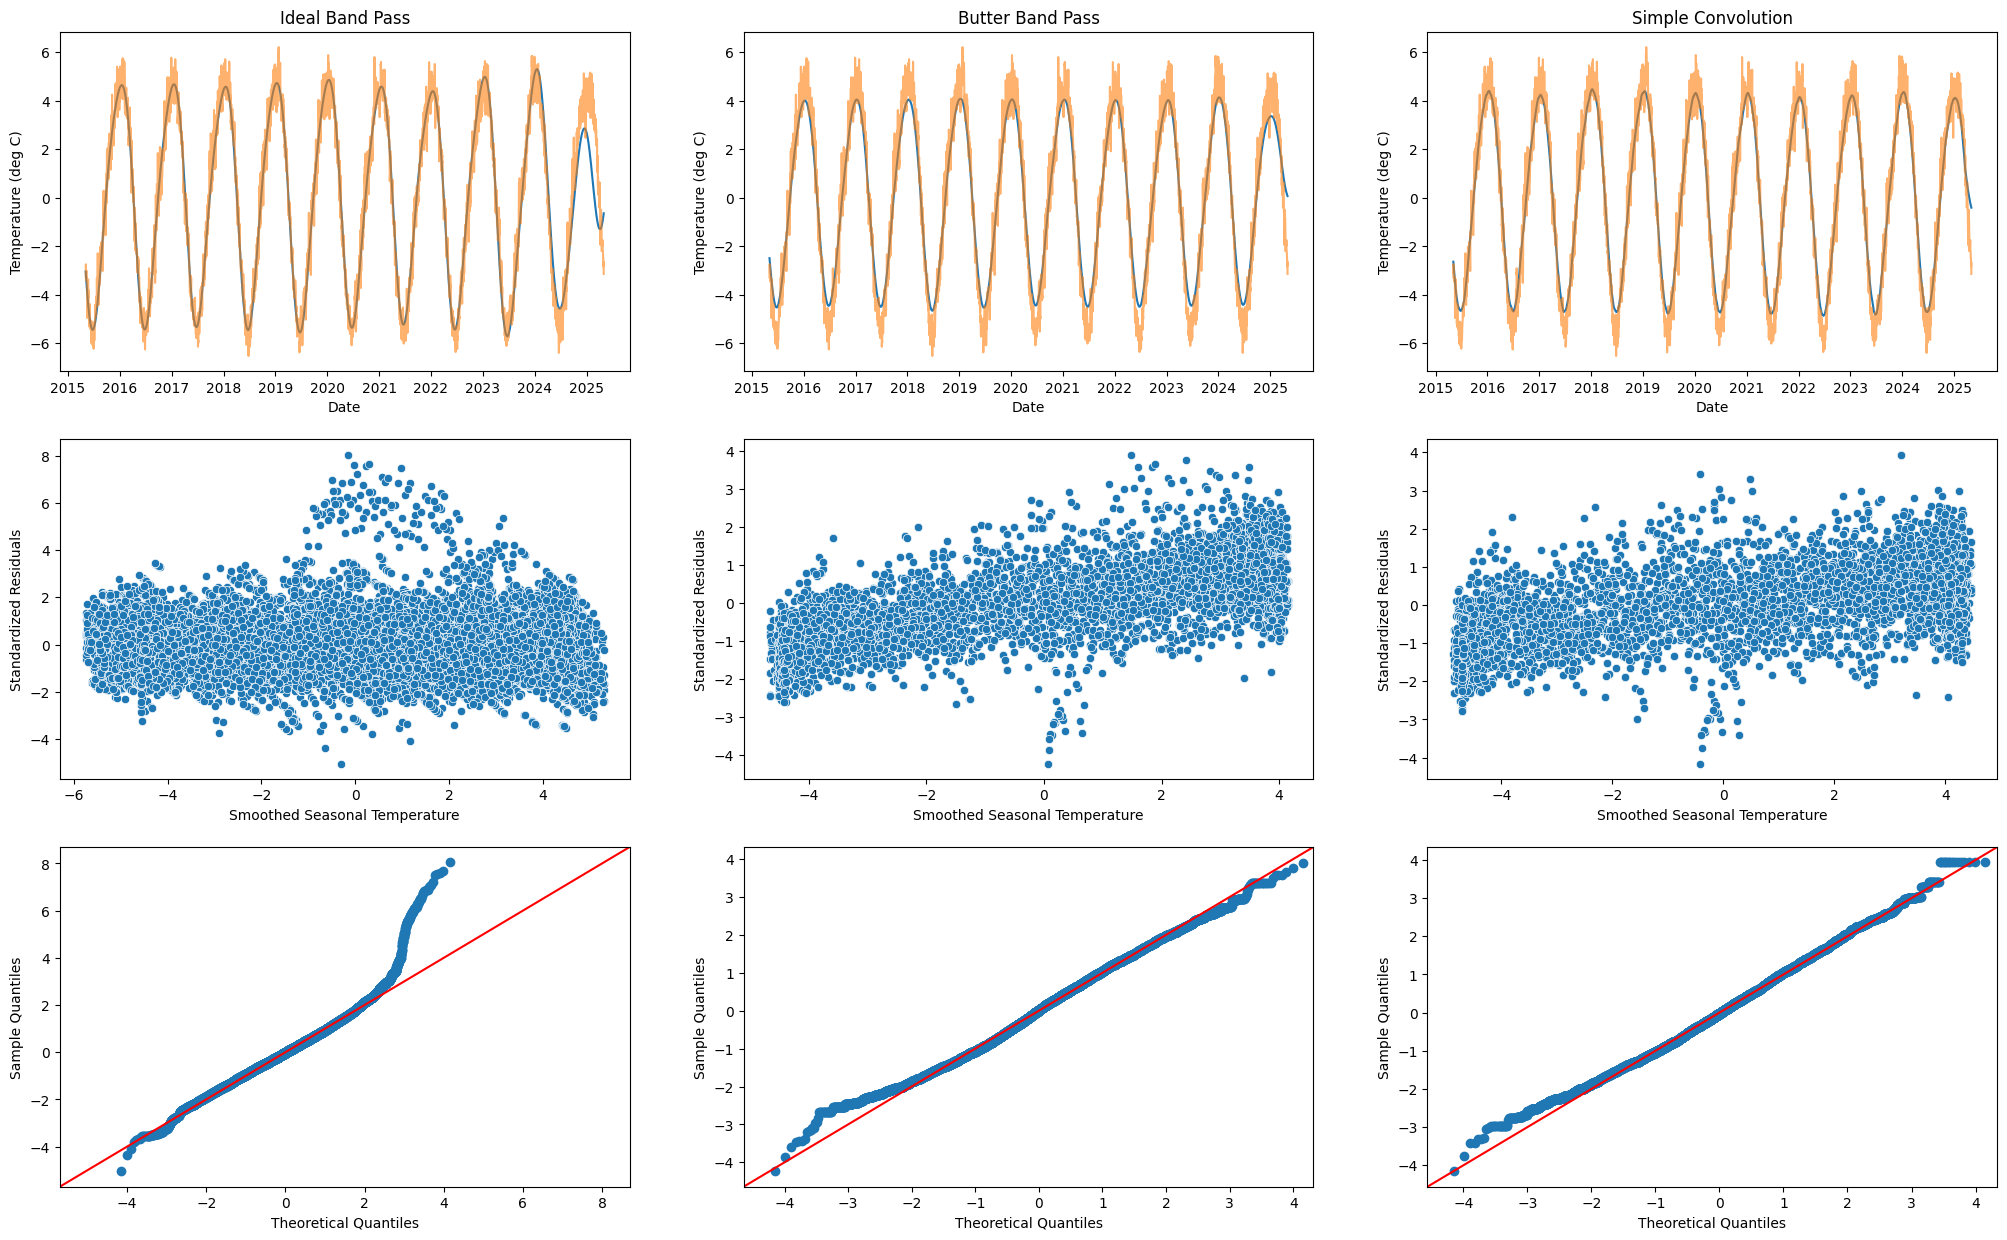

In [59]:
#Apply Smoothing Methods
sm = SeasonalSmooth(c_seasonal)
lowcut, highcut = 0.002, 0.006 #Put slightly below and above to reduce ringing
ideal_band_pass = sm.bandpass_filter(lowcut, highcut)
butter_band_pass = sm.butter_bandpass(1, lowcut, highcut)
simple_convolution = sm.apply_simple_convolution()

#Calculate Residuals
ideal_noise = c_seasonal - ideal_band_pass
butter_noise = c_seasonal - butter_band_pass
convolution_noise = c_seasonal - simple_convolution
residuals = [ideal_noise, butter_noise, convolution_noise]
standardized_residuals = [r/np.std(r) for r in residuals]

#Plot Charts
smooth_curves = [ideal_band_pass, butter_band_pass, simple_convolution]
name_list = ['Ideal Band Pass', 'Butter Band Pass', 'Simple Convolution']
axes_idx = range(len(smooth_curves))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,15))
for idx, curve, name, resid in zip(axes_idx, smooth_curves, name_list, standardized_residuals):
    #Smoothed Curves
    sns.lineplot(curve[-rolling_window:], ax=axes[0, idx])
    axes[0, idx].set_ylabel('Temperature (deg C)')
    axes[0, idx].set_title(name)
    sns.lineplot(c_seasonal[-rolling_window:], alpha=0.6, ax=axes[0, idx])
    
    #Residuals
    sns.scatterplot(x=curve, y=resid, ax=axes[1, idx])
    axes[1, idx].set_ylabel('Standardized Residuals')
    axes[1, idx].set_xlabel('Smoothed Seasonal Temperature')
    
    #QQ-Plot
    qqplot(resid, line='45', ax=axes[2, idx])
    
plt.show()

#### About Fourier Series

Though we could use a rolling window to forecast the seasonal data, we could also use a Fourier Series to derive a truncated equation to ensure a stable approximation.

High frequency terms exponentially decay faster than the low frequency terms, hence the sum will tend to smooth out over time as all the high frequency terms quickly go to 0. Imagine that each individual sine and cosine waves are represented by a vector rotating around a unit circle represented by the equation:
$$
v_n = c_ne^{n2\pi{it}}
$$
where $c_n$ is the complex constant that scales the size of the unit circle and vector length and $n$ initializes the vector position on the unit circle.

The easiest constant term to find is $c_0$ as it represent the center of mass:
$$
f(t) =  ... + c_{-1}e^{-2\pi{it}} + c_0e^0 + c_1e^{2\pi{it}} + ...
$$

Moreover, since every other vector rotates from 0 to 1, the average of those vectors (a periodic function) will be 0. Hence, we are left with:
$$
E[f(t)] = \int^1_0f(t)dt = c_0
$$

Using this logic, if we want to compute a different term, we need to multiply the negative of the unit circle component to $f(t)$ to make that vector hold still:
$$
E[f(t)e^{-2\pi{it}}] = c_1e^{2\pi{it} -2\pi{it}} = c_1 
$$

Then to convert the Fourier Series to the Trigonometric Series, we refer to Euler's formula:
$$
e^{ix} = cos(x) + isin(x)
$$

In order to get the following equation, assuming a period of $2\pi$:
$$
f(x) = a_0 + \sum^\infty_{n=1}[\alpha_ncos(nx)+\beta_nsin(nx)]
$$
$$
a_0 = \frac{1}{2\pi}\int^\pi_{-\pi}f(x)dx \\
\alpha_n = \frac{1}{\pi}\int^\pi_{-\pi}f(x)cos(nx)dx \\
\beta_n = \frac{1}{\pi}\int^\pi_{-\pi}f(x)sin(nx)dx \\
$$

Source: 
- https://www.youtube.com/watch?v=r6sGWTCMz2k
- https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/core-mathematics/pure-maths/algebra/euler-s-formula-and-euler-s-identity.html
- https://www.geeksforgeeks.org/fourier-trigonometric-series/

In our case, since the seasonal component tends to revert back to the mean (typically 0), we have:
$$
f(x) = \sum^\infty_{n=1}[\alpha_ncos(nx)+\beta_nsin(nx)]
$$

Then, since we want the Fourier Series to be in line with the peaks and troughs of our dataset, we have:
$$
f(x) = \sum^\infty_{n=1}[\alpha_ncos(nx + \theta)+\beta_nsin(nx + \phi)]
$$
where $\theta$ and $\phi$ are two independent shifts in the sinusoid.

With reference to a Youtube video by QuantPy, temperature seasonal variation seems to be sufficiently captured by the first order and maybe even just the sine component:
$$
f(x) = \alpha_1cos(x + \theta)+\beta_1sin(x + \phi) \\
f(x) = \beta_1sin(x + \theta)
$$

However, as our period is not $2\pi$ and is 365.25 days as previously proved, we have:
$$f(x) = \beta_1sin(\frac{2\pi{x}}{365.25} + \theta)$$
$$f(x) = \beta_1[sin(\frac{2\pi{x}}{365.25})cos(\theta) + cos(\frac{2\pi{x}}{365.25})sin(\theta)]$$

Let $a = \beta{sin(\theta)}$ and $b = \beta{cos(\theta)}$:
$$f(x) = acos(\frac{2\pi{x}}{365.25}) + bsin(\frac{2\pi{x}}{365.25})$$
where $\beta_1 = \sqrt{a^2 + b^2}$ and $\theta = \arctan{(\frac{a}{b})}$.

Hence, all we need to solve is the best-fit value for $a$ and $b$.

Source: https://www.youtube.com/watch?v=sa7E9qUHYXw

When solving for the coefficients and plotting out the curves, we notice two issues:
1. There is a phase lag in the first 10 years and a phase lead for the last 10 years. In this case, our assumption of using 365.25 days might be incorrect and 365 days may be more appropriate possibly due to the classical decomposition where we used 3650 days as our period.
2. Fitted-curve overestimates the peaks and underestimates the troughs. We are likely missing an additional term like the semi-annual component identified in the frequency analysis.

Consequently, we shall adjust our equation:
$$f(x) = acos(\frac{2\pi{x}}{365}) + bsin(\frac{2\pi{x}}{365}) + ccos(\frac{4\pi{x}}{365}) + dsin(\frac{4\pi{x}}{365})$$

In [60]:
class SeasonalModel:
    def __init__(self, temperature_data:pd.Series):
        self.temperature_data = temperature_data - temperature_data.mean()
        self.time_data = np.array(range(len(temperature_data)))
        
        self.omega = 2*np.pi/365.25
        self.a_coeff = np.cos(self.omega*self.time_data)
        self.b_coeff = np.sin(self.omega*self.time_data)
        self.fourier_curve_fit()
    
    def fourier_curve_fit(self):
        """
        Solve for the best-fit for coefficient a and b for Sydney Temperature Data by minimizing the RSS.
        
        Input:
        temperature_data: A panda series with dates and temperature data in the index and value respectively.
        
        Return:
        Coefficient a and b rounded to 4 decimal place.
        """
        X = np.column_stack([self.a_coeff, self.b_coeff])
        coef = np.linalg.lstsq(X, self.temperature_data, rcond=None)[0]
        self.a, self.b = np.round(coef, 4)
    
    def calculate_curve_data(self) -> pd.Series:
        pred_temp = self.a*self.a_coeff + self.b*self.b_coeff
        return pd.Series(pred_temp, index=self.temperature_data.index)

a = 4.1524, b = 1.3231


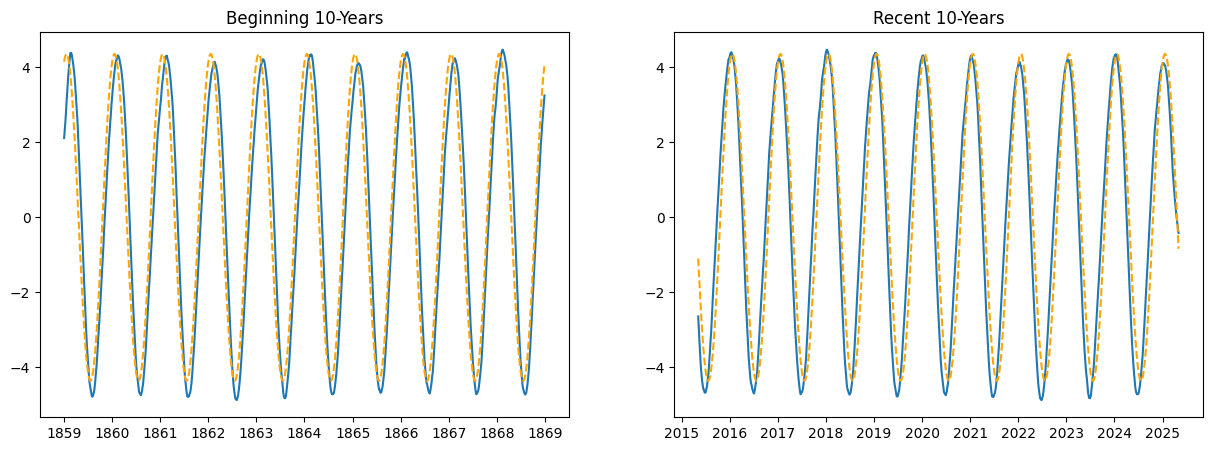

In [61]:
smoothed_season = simple_convolution.copy()
s = SeasonalModel(smoothed_season)
print(f"a = {s.a}, b = {s.b}")

pred_temp = s.calculate_curve_data()
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(smoothed_season[:rolling_window])
axes[0].plot(pred_temp[:rolling_window], linestyle='--', color='orange')
axes[0].set_title('Beginning 10-Years')

axes[1].plot(smoothed_season[-rolling_window:])
axes[1].plot(pred_temp[-rolling_window:], linestyle='--', color='orange')
axes[1].set_title('Recent 10-Years')

plt.show()

The new equation is successful and the fitted curve fits the smoothed curve and even demonstrates better performance on the actual seasonal data.
$$f(x) = 3.4997cos(\frac{2\pi{x}}{365}) + 2.7523sin(\frac{2\pi{x}}{365}) - 0.3661cos(\frac{4\pi{x}}{365}) - 0.1726sin(\frac{4\pi{x}}{365})$$

In [174]:
class SeasonalModel:
    def __init__(self, temperature_data:pd.Series):
        self.temperature_data = temperature_data - temperature_data.mean()
        self.time_data = np.array(range(1, len(temperature_data)+1))
        
        self.omega = 2*np.pi/365
        self.a_coeff = np.cos(self.omega*self.time_data)
        self.b_coeff = np.sin(self.omega*self.time_data)
        self.c_coeff = np.cos(2*self.omega*self.time_data)
        self.d_coeff = np.sin(2*self.omega*self.time_data)
        self.fourier_curve_fit()
    
    def fourier_curve_fit(self):
        """
        Solve for the best-fit for coefficient a and b for Sydney Temperature Data by minimizing the RSS.
        
        Input:
        temperature_data: A panda series with dates and temperature data in the index and value respectively.
        
        Return:
        Coefficient a, b, c and d, rounded to 4 decimal place.
        """
        X = np.column_stack([self.a_coeff, self.b_coeff, self.c_coeff, self.d_coeff])
        coef = np.linalg.lstsq(X, self.temperature_data, rcond=None)[0]
        self.a, self.b, self.c, self.d = np.round(coef, 4)
    
    def calculate_curve_data(self) -> pd.Series:
        pred_temp = self.a*self.a_coeff + self.b*self.b_coeff + self.c*self.c_coeff + self.d*self.d_coeff
        return pd.Series(pred_temp, index=self.temperature_data.index)

a = 3.4518, b = 2.8121, c = -0.36, d = -0.1851


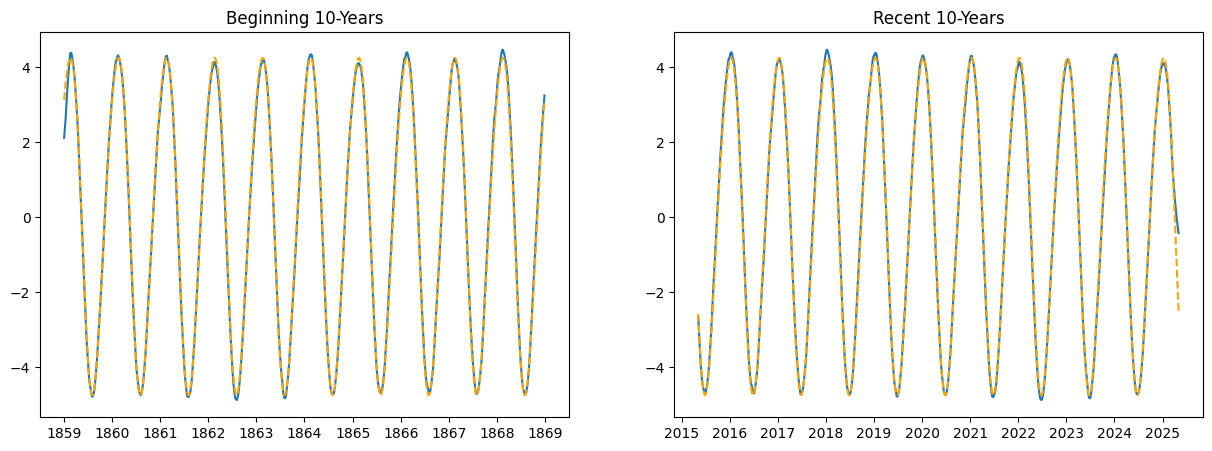

In [175]:
smoothed_season = simple_convolution.copy()
s = SeasonalModel(smoothed_season)
print(f"a = {s.a}, b = {s.b}, c = {s.c}, d = {s.d}")

pred_temp = s.calculate_curve_data()
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(smoothed_season[:rolling_window])
axes[0].plot(pred_temp[:rolling_window], linestyle='--', color='orange')
axes[0].set_title('Beginning 10-Years')

axes[1].plot(smoothed_season[-rolling_window:])
axes[1].plot(pred_temp[-rolling_window:], linestyle='--', color='orange')
axes[1].set_title('Recent 10-Years')

plt.show()

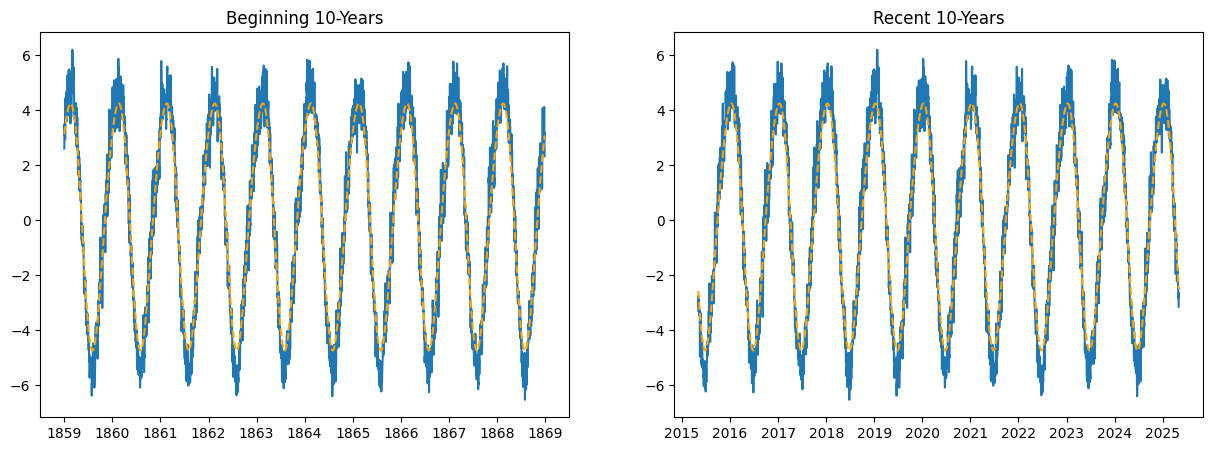

In [176]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(c_seasonal[:rolling_window])
axes[0].plot(pred_temp[:rolling_window], linestyle='--', color='orange')
axes[0].set_title('Beginning 10-Years')

axes[1].plot(c_seasonal[-rolling_window:])
axes[1].plot(pred_temp[-rolling_window:], linestyle='--', color='orange')
axes[1].set_title('Recent 10-Years')

plt.show()

# Equation for Sydney Temperature Movement

Recall that we initially did a naive classical decomposition using an additive model, so the overall equation is:
$$y_t = T_t + S_t + \epsilon_t$$
where t is the timestamp, T is the trend, S is the seasonal and $\epsilon$ is the residual.

Trend is equal to:
$$T_t = ARIMA(1,1,2)$$
$$ARIMA(1,1,2) = \phi_{1}\triangle{y_{t-1}} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \epsilon_t$$

Seasonal is equal to:
$$S_t = 3.4997cos(\frac{2\pi{x}}{365}) + 2.7523sin(\frac{2\pi{x}}{365}) - 0.3661cos(\frac{4\pi{x}}{365}) - 0.1726sin(\frac{4\pi{x}}{365})$$

Residual is equal to:
$$Y_t = AR(15) - c$$
$$Y_t = \sum^{15}_{i=1}\phi_{i}y_{t-1} + \epsilon_t$$

This model is unable to forecast far into the future as we do not know the values of the remaining noise components. Data needs to be constantly updated in order to remain accurate. 

However, we can use this model to conduct a monte carlo simulation for thousands of different paths. Of which, we will dive into in a different notebook.

In [224]:
best_arima.save('trend_model.pkl')
c_residual_ar_model.save('residual_model.pkl')

In [207]:
class TemperatureModel:
    def __init__(self, trend_model, residual_model, forecast_t:int, training_periods:int=60753, latest_temp:float=19.4078):
        self.forecast_t = forecast_t
        self.latest_temp = latest_temp
        self.training_periods = training_periods
        self.trend_model = trend_model
        self.residual_model = residual_model
        
        #Generate forecast periods
        self.t = self.forecast_t + self.training_periods
        self.time = np.arange(self.training_periods+1, self.t+1)
        
        self.pipeline()
        
    def get_seasonal_data(self) -> np.array:
        omega = 2*np.pi/365
        ot = omega*self.time
        
        a = 3.4997*np.cos(ot)
        b = 2.7523*np.sin(ot)
        c = -0.3661*np.cos(2*ot)
        d = -0.1726*np.sin(2*ot)
        result = a+b+c+d
        return result
    
    def get_trend_data(self) -> np.array:
        standardized_forecasts = self.trend_model.forecast(self.forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        forecasts = standardized_forecasts*TREND_STD + TREND_MEAN
        result = self.latest_temp + np.cumsum(forecasts)
        return result.values
    
    def get_residual_data(self) -> np.array:
        result = self.residual_model.forecast(self.forecast_t)
        return result.values
    
    def pipeline(self):
        self.seasonal = self.get_seasonal_data()
        self.trend = self.get_trend_data()
        self.residual = self.get_residual_data()
        self.forecast = self.seasonal + self.trend + self.residual